In [131]:
import polars as pl 
import re
wb_latam = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/wb_latam.csv")
destatis_0001  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")
destatis_0003  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/outputs/destatis_0003_clean.csv")
destatis_0004  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0004_clean.csv")
daad_clean     = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/daad_clean.csv")

In [132]:
latam = pl.read_csv('/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/latam_countries.csv')
latam = latam.select(
    pl.col('country_en').str.strip_chars().alias('country_en'),
    pl.col('iso3').str.strip_chars().alias('iso3')
)

In [133]:
ALIASES = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Dominican Republic": "Dominican Republic",
    "Bahamas": "Bahamas",  
    "Côte d'Ivoire": "Cote d'Ivoire", 
}




In [134]:
def apply_alias_expr(col: str):
    expr = pl.col(col)
    for src, tgt in ALIASES.items():
        expr = expr.map_elements(lambda x, src=src, tgt=tgt: tgt if x == src else x)
    return expr


In [135]:
def to_year(expr):
    return pl.col(expr).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32)


In [136]:
def to_int(expr):
    return (
        pl.when(pl.col(expr).is_null()).then(None)
        .when(pl.col(expr).dtype == pl.Utf8)
            .then(pl.col(expr).str.replace_all(',','').cast(pl.Int64, strict=False))
        .otherwise(pl.col(expr).cast(pl.Int64, strict=False))
        .alias(expr)
        
    )

In [137]:
def extract_year(colname: str):
    return (
        pl.col(colname)
        .cast(pl.Utf8)
        .str.extract(r"(\d{4})")
        .cast(pl.Int32)
    )

In [118]:
def to_int(colname: str):
    return (
        pl.when(pl.col(colname).is_null()).then(None)
        .otherwise(pl.col(colname).cast(pl.Utf8).str.replace_all(",", "").cast(pl.Int64, strict=False))
        .alias(colname)
    )

## female scholarships DAAD tables

In [138]:
# keep only LATAM countries
daad_latam = (
    daad_clean
    .with_columns(apply_alias_expr('Country').alias('Country'))
    .join(latam, left_on='Country', right_on='country_en', how='inner')
)

In [139]:
#female scholarship measure
female_cols = [c for c in daad_latam.columns if c.endswith('_female')]
prefer = ['total_female', 'individual_female', 'project_female']
pick = [c for c in prefer if c in female_cols]

daad_female = (
    daad_latam
    .with_columns([
        (pl.col('total_female') if 'total_female' in daad_latam.columns
         else pl.sum_horizontal([pl.col(c) for c in pick])).alias('daad_female_scholarships')
    ])
    .select(['Country', 'iso3', 'year', 'daad_female_scholarships'])
    .rename({'Country':'country'})
)

print(daad_female.head(10))

shape: (10, 4)
┌────────────────────┬──────┬──────┬──────────────────────────┐
│ country            ┆ iso3 ┆ year ┆ daad_female_scholarships │
│ ---                ┆ ---  ┆ ---  ┆ ---                      │
│ str                ┆ str  ┆ i64  ┆ i64                      │
╞════════════════════╪══════╪══════╪══════════════════════════╡
│ Argentina          ┆ ARG  ┆ 2020 ┆ 428                      │
│ Bahamas            ┆ BHS  ┆ 2020 ┆ 5                        │
│ Barbados           ┆ BRB  ┆ 2020 ┆ 27                       │
│ Belize             ┆ BLZ  ┆ 2020 ┆ 301                      │
│ Brazil             ┆ BRA  ┆ 2020 ┆ 452                      │
│ Chile              ┆ CHL  ┆ 2020 ┆ 198                      │
│ Costa Rica         ┆ CRI  ┆ 2020 ┆ 76                       │
│ Dominica           ┆ DMA  ┆ 2020 ┆ 62                       │
│ Dominican Republic ┆ DOM  ┆ 2020 ┆ 59                       │
│ Ecuador            ┆ ECU  ┆ 2020 ┆ 157                      │
└────────────────────┴───

## Female students in Germany - DESTATIS

In [121]:
destatis_0001 = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")
print(destatis_0001.columns)
print(destatis_0001.head(5))


['year', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'total_total']
shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ year      ┆ germans_m ┆ germans_f ┆ germans_t ┆ … ┆ foreigner ┆ total_mal ┆ total_fem ┆ total_to │
│ ---       ┆ ale       ┆ emale     ┆ otal      ┆   ┆ s_total   ┆ e         ┆ ale       ┆ tal      │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ WT        ┆ 907403    ┆ 727254    ┆ 1634657   ┆ … ┆ 165994    ┆ 999724    ┆ 800927    ┆ 1800651  │
│ 1998/99   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ WT        

In [122]:
## FOREIGN FEMALE STUDENTS - DF 0001
destastis_year_foreign_fem = (
    destatis_0001
    .with_columns([
        extract_year('year').alias('year'),
        to_int('foreigners_female')
    ])
    .select(['year', 'foreigners_female'])
    .rename({'foreigners_female': 'destatis_foreign_female_total'})
)

print(destastis_year_foreign_fem)

shape: (27, 2)
┌──────┬───────────────────────────────┐
│ year ┆ destatis_foreign_female_total │
│ ---  ┆ ---                           │
│ i32  ┆ i64                           │
╞══════╪═══════════════════════════════╡
│ 1998 ┆ 73673                         │
│ 1999 ┆ 79605                         │
│ 2000 ┆ 87121                         │
│ 2001 ┆ 98410                         │
│ 2002 ┆ 109821                        │
│ …    ┆ …                             │
│ 2020 ┆ 193470                        │
│ 2021 ┆ 205538                        │
│ 2022 ┆ 213717                        │
│ 2023 ┆ 218651                        │
│ 2024 ┆ 227670                        │
└──────┴───────────────────────────────┘


In [123]:
## BY FIELD OF STUDY DF 0003
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),   
        pl.col("field").alias("field"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")   
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print(destatis_fields.head(20))
print(destatis_fields.select("year").unique().sort("year"))


shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2013 ┆ Waste Management                ┆ 4                       │
│ 2013 ┆ African Studies                 ┆ 178                     │
│ 2013 ┆ Agricultural Biology            ┆ 87                      │
│ 2013 ┆ Agricultural Economics          ┆ 173                     │
│ 2013 ┆ Agricultural Science/Agricultu… ┆ 773                     │
│ …    ┆ …                               ┆ …                       │
│ 2013 ┆ Arabic/Arabic Studies           ┆ 51                      │
│ 2013 ┆ Work Studies/Business Studies   ┆ 49                      │
│ 2013 ┆ Occupational Guidance and Care… ┆ 1                       │
│ 2013 ┆ Labour Adm

In [124]:
## by degree type - df 0004
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").alias("degree"),
        to_int("foreigners_female")
    ])
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print(destatis_degrees.filter(pl.col("year") == 2020).sort("foreign_female_by_degree", descending=True).head(10))


shape: (0, 3)
┌──────┬────────┬──────────────────────────┐
│ year ┆ degree ┆ foreign_female_by_degree │
│ ---  ┆ ---    ┆ ---                      │
│ i32  ┆ str    ┆ i64                      │
╞══════╪════════╪══════════════════════════╡
└──────┴────────┴──────────────────────────┘


In [125]:
print("Shape:", destatis_0004.shape)
print("Columns:", destatis_0004.columns)
print(destatis_0004.head(20))


Shape: (293, 11)
Columns: ['year', 'degree', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'general_total']
shape: (20, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ year      ┆ degree    ┆ germans_m ┆ germans_f ┆ … ┆ foreigner ┆ total_mal ┆ total_fem ┆ general_ │
│ ---       ┆ ---       ┆ ale       ┆ emale     ┆   ┆ s_total   ┆ e         ┆ ale       ┆ total    │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ WT        ┆ Administr ┆ 681       ┆ 2440      ┆ … ┆ 2         ┆ 681       ┆ 2442      ┆ 3123     │
│ 2024/25   ┆ ation of  ┆           ┆           ┆   ┆           ┆         

In [126]:
print(destatis_0004.select("foreigners_female").head(10))


shape: (10, 1)
┌───────────────────┐
│ foreigners_female │
│ ---               │
│ str               │
╞═══════════════════╡
│ 2                 │
│ 348               │
│ 100               │
│ 419               │
│ 169               │
│ 308               │
│ 361               │
│ 1253              │
│ 830               │
│ 18                │
└───────────────────┘


In [127]:
# 1. Forward-fill year
df_ffill = destatis_0004.with_columns(
    pl.when(pl.col("year").is_not_null())
      .then(pl.col("year"))
      .otherwise(None)
      .alias("year_tmp")
)

# propagate last non-null downwards
df_ffill = df_ffill.with_columns(
    df_ffill["year_tmp"].forward_fill().alias("year_filled")
)

# 2. Extract numeric year (first 4 digits)
df_ffill = df_ffill.with_columns(
    pl.col("year_filled").cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32).alias("year")
)

# 3. Cast foreigners_female to int
df_ffill = df_ffill.with_columns(
    pl.col("foreigners_female").cast(pl.Int64, strict=False)
)

# 4. Build final table
destatis_degrees = (
    df_ffill
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
    .filter(pl.col("year").is_not_null())   # drop junk rows
)

print("Shape:", destatis_degrees.shape)
print(destatis_degrees.head(20))


Shape: (293, 3)
shape: (20, 3)
┌──────┬─────────────────────────────────┬──────────────────────────┐
│ year ┆ degree                          ┆ foreign_female_by_degree │
│ ---  ┆ ---                             ┆ ---                      │
│ i32  ┆ str                             ┆ i64                      │
╞══════╪═════════════════════════════════╪══════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                        │
│ 2024 ┆ Administrative Science/Public … ┆ 348                      │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                      │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                      │
│ 2024 ┆ African Studies                 ┆ 169                      │
│ …    ┆ …                               ┆ …                        │
│ 2024 ┆ Applied Systems Science         ┆ 442                      │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                       │
│ 2024 ┆ Archaeology                     ┆ 347             

In [128]:
## FOREIGNERS FEMALE BY FIELDS - 0003
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),  
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
)


destatis_fields = destatis_fields.with_columns(
    pl.col("year").fill_null(strategy="forward")
)


destatis_fields = (
    destatis_fields
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print("Shape:", destatis_fields.shape)
print(destatis_fields.head(20))


Shape: (3268, 3)
shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2013 ┆ Waste Management                ┆ 4                       │
│ 2013 ┆ African Studies                 ┆ 178                     │
│ 2013 ┆ Agricultural Biology            ┆ 87                      │
│ 2013 ┆ Agricultural Economics          ┆ 173                     │
│ 2013 ┆ Agricultural Science/Agricultu… ┆ 773                     │
│ …    ┆ …                               ┆ …                       │
│ 2013 ┆ Arabic/Arabic Studies           ┆ 51                      │
│ 2013 ┆ Work Studies/Business Studies   ┆ 49                      │
│ 2013 ┆ Occupational Guidance and Care… ┆ 1                       │
│ 

In [129]:
## FOREIGNERS MALE BY FIELDS - 0003
destatis_fields_male = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),  
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_male")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "field", "foreigners_male"])
    .rename({"foreigners_male": "foreign_male_by_field"})
)

print("Shape:", destatis_fields_male.shape)
print(destatis_fields_male.head(20))


Shape: (3268, 3)
shape: (20, 3)
┌──────┬─────────────────────────────────┬───────────────────────┐
│ year ┆ field                           ┆ foreign_male_by_field │
│ ---  ┆ ---                             ┆ ---                   │
│ i32  ┆ str                             ┆ i64                   │
╞══════╪═════════════════════════════════╪═══════════════════════╡
│ 2013 ┆ Waste Management                ┆ 9                     │
│ 2013 ┆ African Studies                 ┆ 185                   │
│ 2013 ┆ Agricultural Biology            ┆ 97                    │
│ 2013 ┆ Agricultural Economics          ┆ 208                   │
│ 2013 ┆ Agricultural Science/Agricultu… ┆ 981                   │
│ …    ┆ …                               ┆ …                     │
│ 2013 ┆ Arabic/Arabic Studies           ┆ 73                    │
│ 2013 ┆ Work Studies/Business Studies   ┆ 23                    │
│ 2013 ┆ Occupational Guidance and Care… ┆ null                  │
│ 2013 ┆ Labour Administration

In [140]:
import matplotlib.pyplot as plt

# Prepare data (already done before)
df_top = df_last10.filter(pl.col("field").is_in(top_fields))

colors = ["steelblue", "salmon", "seagreen", "darkorange", "purple"]
fields = top_fields

plt.figure(figsize=(12, 7))

for color, field in zip(colors, fields):
    df_field = (
        df_top.filter(pl.col("field") == field)
        .select(["year", "foreign_male_by_field", "foreign_female_by_field"])
        .sort("year")
    )

    years  = df_field["year"].to_list()
    male   = [x or 0 for x in df_field["foreign_male_by_field"].to_list()]
    female = [x or 0 for x in df_field["foreign_female_by_field"].to_list()]

    # Male = solid line
    plt.plot(years, male, marker="o", linestyle="-", color=color, label=f"{field} (Male)")

    # Female = dashed line
    plt.plot(years, female, marker="s", linestyle="--", color=color, label=f"{field} (Female)")

plt.title("Foreign Students by Gender – Top 5 Fields (Last 10 Years)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Students")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'df_last10' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# pick the most recent year in your dataset
latest_year = df_last10["year"].max()

df_latest = (
    df_last10.filter(pl.col("year") == latest_year)
    .filter(pl.col("field").is_in(top_fields))
    .sort((pl.col("foreign_female_by_field") + pl.col("foreign_male_by_field")), descending=True)
)

fields = df_latest["field"].to_list()
male   = [x or 0 for x in df_latest["foreign_male_by_field"].to_list()]
female = [x or 0 for x in df_latest["foreign_female_by_field"].to_list()]

x = np.arange(len(fields))
width = 0.35

plt.figure(figsize=(10,6))

# Male bars
plt.bar(x - width/2, male, width, label="Male", color="steelblue")

# Female bars
plt.bar(x + width/2, female, width, label="Female", color="salmon")

# Formatting
plt.xticks(x, fields, rotation=30, ha="right")
plt.ylabel("Number of Students")
plt.title(f"Foreign Students by Gender – Top 5 Fields ({latest_year})")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'df_last10' is not defined

In [ ]:
latam_fields = (
    wb_daad
    .join(destatis_0003, on="year", how="inner")  # join on year
    .group_by("field")
    .agg([
        pl.col("foreigners_female").sum().alias("latina_female_total"),
        pl.col("foreigners_male").sum().alias("latino_male_total")
    ])
    .sort("latina_female_total", descending=True)
    .head(10)   # Top 10 by female, but includes both genders
)

print(latam_fields)


NameError: name 'wb_daad' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fields = latam_fields["field"].to_list()
female = latam_fields["latina_female_total"].to_list()
male   = latam_fields["latino_male_total"].to_list()

x = np.arange(len(fields))
width = 0.35

colors = cm.Set2(np.linspace(0, 1, 2))  # 2 pastel colors
female_color, male_color = colors[0], colors[1]

plt.figure(figsize=(10,6))

plt.bar(x - width/2, male, width, label="Latino Men", color=male_color)
plt.bar(x + width/2, female, width, label="Latina Women", color=female_color)

plt.xticks(x, fields, rotation=30, ha="right")
plt.ylabel("Number of Students")
plt.title("Latin American Students in Germany – Top 10 Fields (2013–2024)")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'latam_fields' is not defined

In [ ]:
latam_fields_norm = (
    latam_fields
    .with_columns(
        (pl.col("latina_female_total") / 
         (pl.col("latina_female_total") + pl.col("latino_male_total")) * 100
        ).alias("female_pct"),
        (pl.col("latino_male_total") / 
         (pl.col("latina_female_total") + pl.col("latino_male_total")) * 100
        ).alias("male_pct")
    )
)

print(latam_fields_norm)


shape: (10, 5)
┌───────────────────────────────┬─────────────────────┬───────────────────┬────────────┬───────────┐
│ field                         ┆ latina_female_total ┆ latino_male_total ┆ female_pct ┆ male_pct  │
│ ---                           ┆ ---                 ┆ ---               ┆ ---        ┆ ---       │
│ str                           ┆ i64                 ┆ i64               ┆ f64        ┆ f64       │
╞═══════════════════════════════╪═════════════════════╪═══════════════════╪════════════╪═══════════╡
│ Business Administration       ┆ 3499494             ┆ 2949888           ┆ 54.26092   ┆ 45.73908  │
│ Medicine (General Medicine)   ┆ 1620004             ┆ 1235231           ┆ 56.738027  ┆ 43.261973 │
│ International Business        ┆ 1525481             ┆ 1360877           ┆ 52.851413  ┆ 47.148587 │
│ Studies…                      ┆                     ┆                   ┆            ┆           │
│ Computer Science              ┆ 1498863             ┆ 4168770           ┆ 

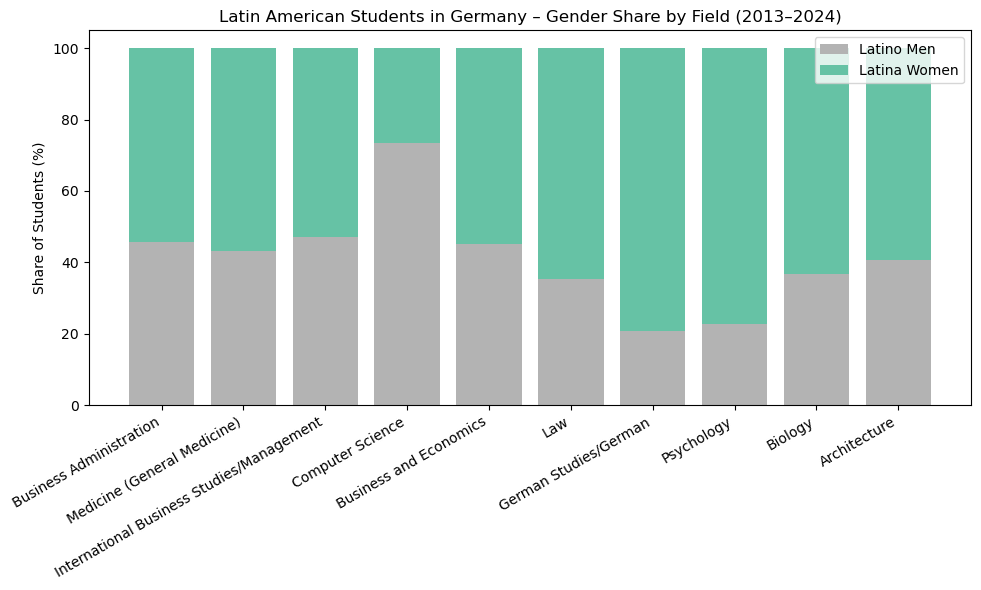

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fields = latam_fields_norm["field"].to_list()
female_pct = latam_fields_norm["female_pct"].to_list()
male_pct   = latam_fields_norm["male_pct"].to_list()

x = np.arange(len(fields))

# Pastel colors
colors = cm.Set2(np.linspace(0, 1, 2))
female_color, male_color = colors[0], colors[1]

plt.figure(figsize=(10,6))

# Stacked bars
plt.bar(x, male_pct, label="Latino Men", color=male_color)
plt.bar(x, female_pct, bottom=male_pct, label="Latina Women", color=female_color)

# Formatting
plt.xticks(x, fields, rotation=30, ha="right")
plt.ylabel("Share of Students (%)")
plt.title("Latin American Students in Germany – Gender Share by Field (2013–2024)")
plt.legend()
plt.tight_layout()
plt.show()


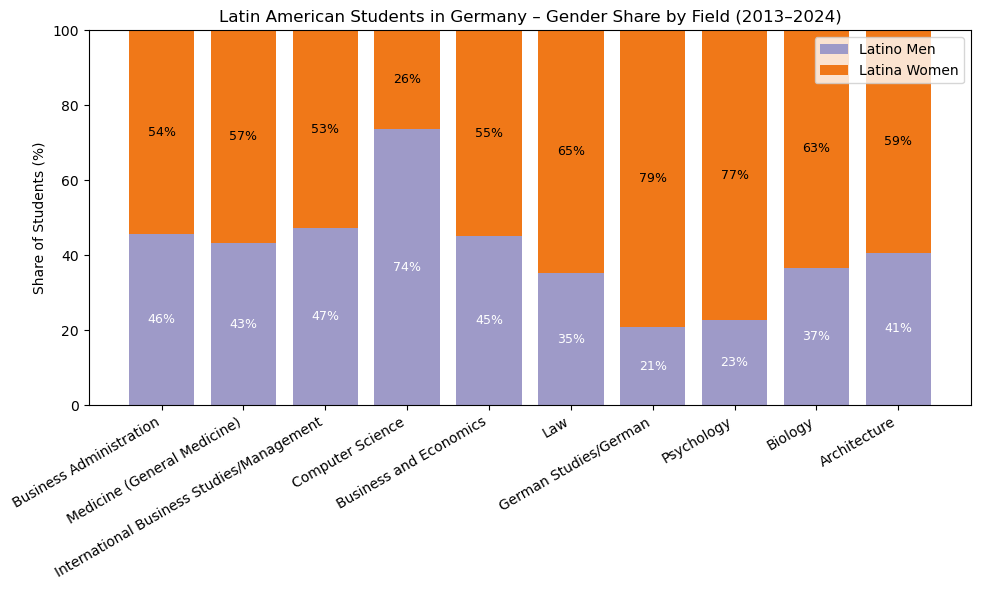

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fields = latam_fields_norm["field"].to_list()
female_pct = latam_fields_norm["female_pct"].to_list()
male_pct   = latam_fields_norm["male_pct"].to_list()

x = np.arange(len(fields))

# Smooth pastel colors (yellow + purple)
female_color = cm.YlOrBr(0.6)   # soft yellow-orange
male_color   = cm.Purples(0.5)  # soft purple

plt.figure(figsize=(10,6))

# Plot stacked bars
bars_male = plt.bar(x, male_pct, label="Latino Men", color=male_color)
bars_female = plt.bar(x, female_pct, bottom=male_pct, label="Latina Women", color=female_color)

# Add % labels inside bars
for i, (m, f) in enumerate(zip(male_pct, female_pct)):
    # Male %
    if m > 5:  # only label if big enough
        plt.text(i, m/2, f"{m:.0f}%", ha="center", va="center", color="white", fontsize=9)
    # Female %
    if f > 5:
        plt.text(i, m + f/2, f"{f:.0f}%", ha="center", va="center", color="black", fontsize=9)

# Formatting
plt.xticks(x, fields, rotation=30, ha="right")
plt.ylabel("Share of Students (%)")
plt.title("Latin American Students in Germany – Gender Share by Field (2013–2024)")
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [ ]:
import os
output_dir = "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs"
os.makedirs(output_dir, exist_ok=True)


destatis_fields.write_csv(f"{output_dir}/destatis_fields_foreign_female.csv")
destatis_degrees.write_csv(f"{output_dir}/destatis_degrees_foreign_female.csv")

print(" Both CSVs exported successfully to 'outputs/'")


 Both CSVs exported successfully to 'outputs/'


## WORLD BANK LATAM 

In [ ]:
print("World Bank Latam shape:", wb_latam.shape)
print(wb_latam.head(10))

World Bank Latam shape: (516, 4)
shape: (10, 4)
┌────────────────────────┬──────┬──────┬─────────────────────┐
│ country                ┆ iso3 ┆ year ┆ wb_attendance_ratio │
│ ---                    ┆ ---  ┆ ---  ┆ ---                 │
│ str                    ┆ str  ┆ i64  ┆ f64                 │
╞════════════════════════╪══════╪══════╪═════════════════════╡
│ Antigua and Barbuda    ┆ ATG  ┆ 2013 ┆ null                │
│ Argentina              ┆ ARG  ┆ 2013 ┆ 98.193382           │
│ Aruba                  ┆ ABW  ┆ 2013 ┆ 23.472099           │
│ Bahamas, The           ┆ BHS  ┆ 2013 ┆ null                │
│ Barbados               ┆ BRB  ┆ 2013 ┆ null                │
│ Belize                 ┆ BLZ  ┆ 2013 ┆ 29.732929           │
│ Bermuda                ┆ BMU  ┆ 2013 ┆ 50.517349           │
│ Bolivia                ┆ BOL  ┆ 2013 ┆ null                │
│ Brazil                 ┆ BRA  ┆ 2013 ┆ 51.04491            │
│ British Virgin Islands ┆ VGB  ┆ 2013 ┆ null                │
└──────

## MERGING WB + DAAD - MASTER COUNTRY-YEAR TABLE

In [ ]:
wb_daad = (
    wb_latam.join(
        daad_female,
        on=["country", "iso3", "year"],
        how="inner"
    )
    .sort(["country", "year"])
    .with_columns([
        (pl.col("daad_female_scholarships") / pl.col("wb_attendance_ratio"))
        .alias("share_scholarships_vs_enrollment")
    ])
)

print("Shape:", wb_daad.shape)
print(wb_daad.head(10))


Shape: (230, 6)
shape: (10, 6)
┌───────────┬──────┬──────┬─────────────────────┬─────────────────────────┬────────────────────────┐
│ country   ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_scholarship ┆ share_scholarships_vs_ │
│ ---       ┆ ---  ┆ ---  ┆ ---                 ┆ s                       ┆ enrollme…              │
│ str       ┆ str  ┆ i64  ┆ f64                 ┆ ---                     ┆ ---                    │
│           ┆      ┆      ┆                     ┆ i64                     ┆ f64                    │
╞═══════════╪══════╪══════╪═════════════════════╪═════════════════════════╪════════════════════════╡
│ Argentina ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                     ┆ 7.597253               │
│ Argentina ┆ ARG  ┆ 2014 ┆ 101.442146          ┆ 799                     ┆ 7.876411               │
│ Argentina ┆ ARG  ┆ 2015 ┆ 105.110039          ┆ 976                     ┆ 9.285507               │
│ Argentina ┆ ARG  ┆ 2016 ┆ 109.326408          ┆ 2991      

In [ ]:
print(wb_daad.schema)   # column names + dtypes


Schema({'country': String, 'iso3': String, 'year': Int64, 'wb_attendance_ratio': Float64, 'daad_female_scholarships': Int64, 'share_scholarships_vs_enrollment': Float64})


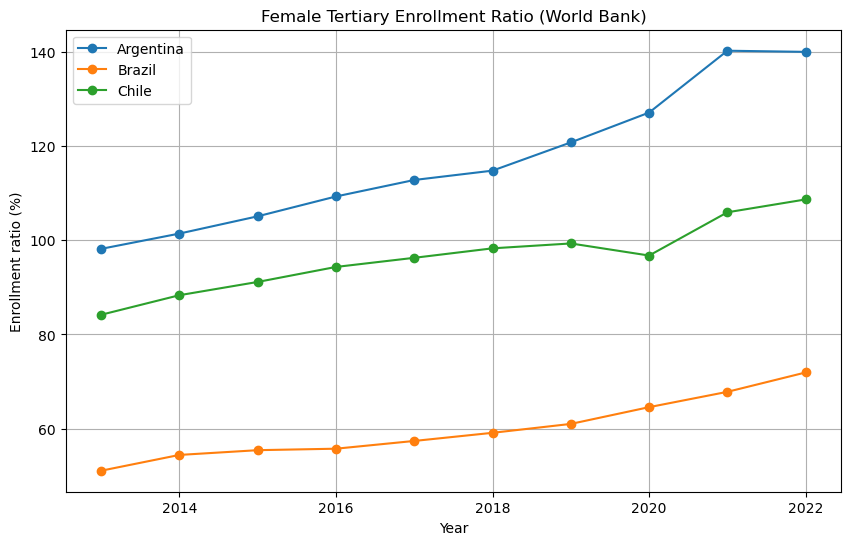

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["wb_attendance_ratio"].to_numpy(),
        marker="o",
        label=country
    )

plt.title("Female Tertiary Enrollment Ratio (World Bank)")
plt.xlabel("Year")
plt.ylabel("Enrollment ratio (%)")
plt.legend()
plt.grid(True)
plt.show()


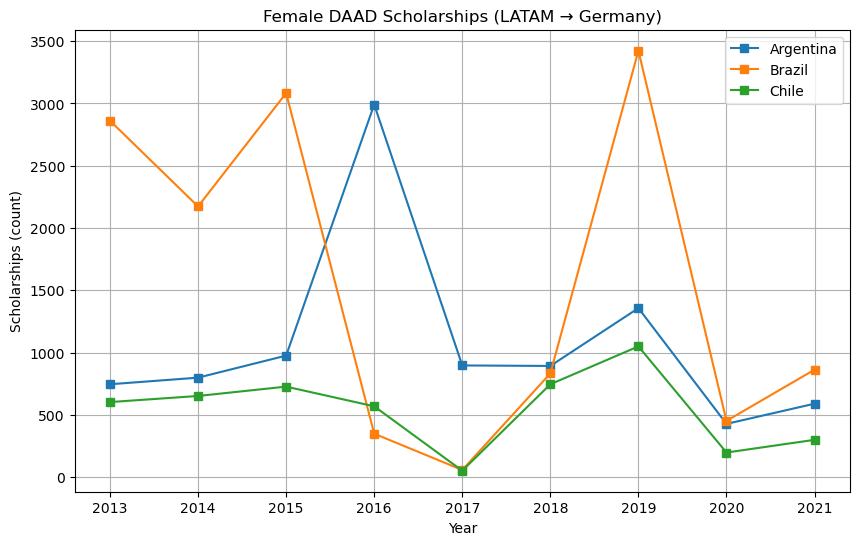

In [ ]:
plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["daad_female_scholarships"].to_numpy(),
        marker="s",
        label=country
    )

plt.title("Female DAAD Scholarships (LATAM → Germany)")
plt.xlabel("Year")
plt.ylabel("Scholarships (count)")
plt.legend()
plt.grid(True)
plt.show()


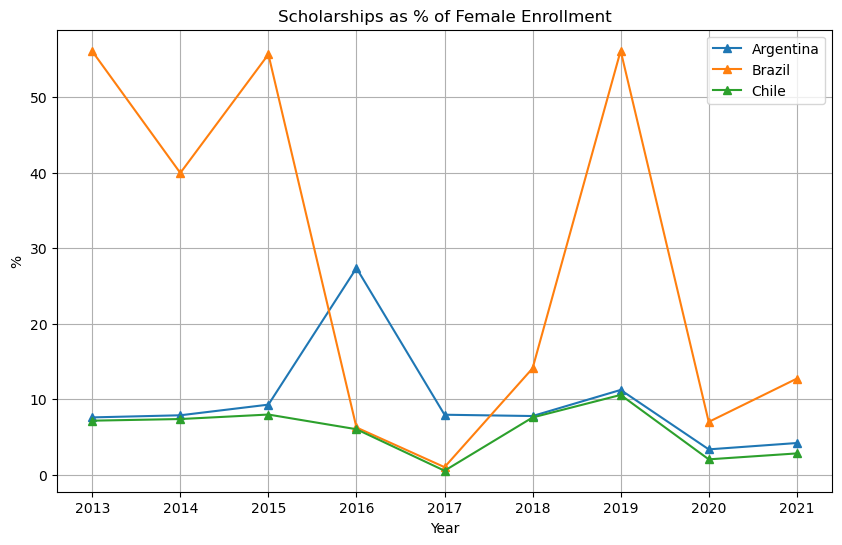

In [ ]:
plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["share_scholarships_vs_enrollment"].to_numpy(),
        marker="^",
        label=country
    )

plt.title("Scholarships as % of Female Enrollment")
plt.xlabel("Year")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()


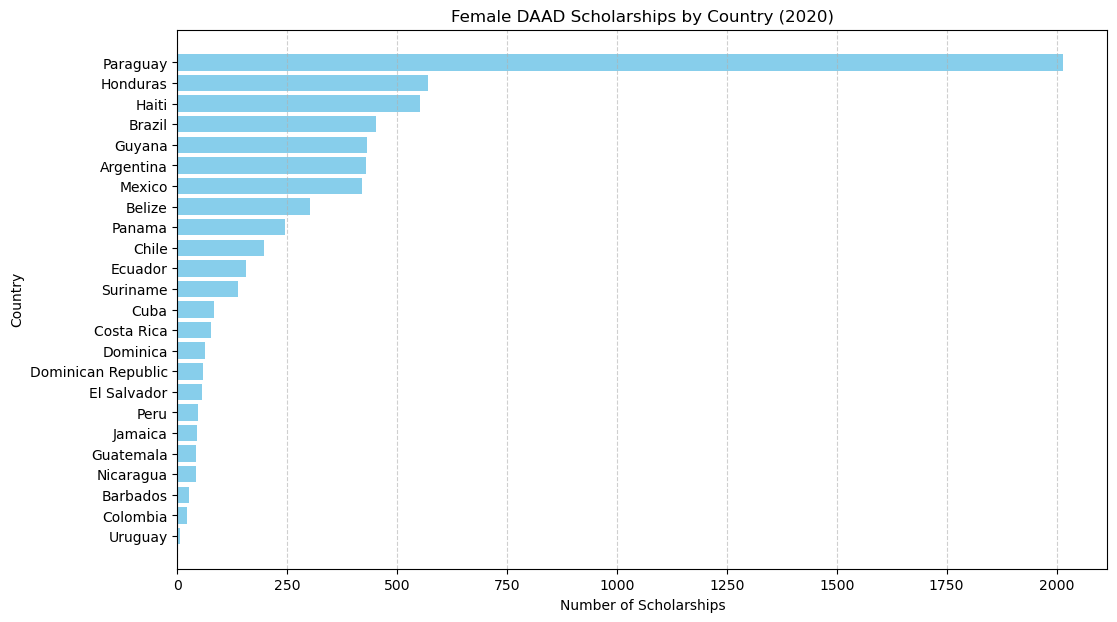

In [ ]:
import matplotlib.pyplot as plt

# Pick a year for comparison
year_focus = 2020

# Filter and sort
data = (
    wb_daad.filter(pl.col("year") == year_focus)
           .select(["country", "daad_female_scholarships"])
           .drop_nulls()
           .sort("daad_female_scholarships", descending=True)
)

countries = data["country"].to_list()
values = data["daad_female_scholarships"].to_list()

# Plot
plt.figure(figsize=(12,7))
plt.barh(countries, values, color="skyblue")
plt.title(f"Female DAAD Scholarships by Country ({year_focus})")
plt.xlabel("Number of Scholarships")
plt.ylabel("Country")
plt.gca().invert_yaxis()  # biggest at the top
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


## MERGING WB_DAAD WITH DESTATIS

In [ ]:
## total arrivals
master = (
    wb_daad.join(
        destastis_year_foreign_fem,  
        on="year",
        how="left"
    )
    .rename({"destatis_foreign_female_total": "destatis_female_in_germany"})
)

print("Master funnel dataset")
print("Shape:", master.shape)
print(master.head(10))

Master funnel dataset
Shape: (230, 7)
shape: (10, 7)
┌───────────┬──────┬──────┬──────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ country   ┆ iso3 ┆ year ┆ wb_attendance_ra ┆ daad_female_sch ┆ share_scholarsh ┆ destatis_female │
│ ---       ┆ ---  ┆ ---  ┆ tio              ┆ olarships       ┆ ips_vs_enrollme ┆ _in_germany     │
│ str       ┆ str  ┆ i64  ┆ ---              ┆ ---             ┆ …               ┆ ---             │
│           ┆      ┆      ┆ f64              ┆ i64             ┆ ---             ┆ i64             │
│           ┆      ┆      ┆                  ┆                 ┆ f64             ┆                 │
╞═══════════╪══════╪══════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ Argentina ┆ ARG  ┆ 2013 ┆ 98.193382        ┆ 746             ┆ 7.597253        ┆ 148675          │
│ Argentina ┆ ARG  ┆ 2014 ┆ 101.442146       ┆ 799             ┆ 7.876411        ┆ 158064          │
│ Argentina ┆ ARG  ┆ 2015 ┆ 105.110039

In [ ]:
# Fix null years by forward-filling within the table
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")  # propagate year downward
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print(" Destatis fields fixed")
print(destatis_fields.filter(pl.col("year") == 2024).head(20))


 Destatis fields fixed
shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Waste Management                ┆ 2                       │
│ 2024 ┆ African Studies                 ┆ 169                     │
│ 2024 ┆ Agricultural Biology            ┆ 308                     │
│ 2024 ┆ Agricultural Economics          ┆ 361                     │
│ 2024 ┆ Agricultural Science/Agricultu… ┆ 1253                    │
│ …    ┆ …                               ┆ …                       │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                      │
│ 2024 ┆ Work Studies/Business Studies   ┆ 58                      │
│ 2024 ┆ Occupational Guidance and Care… ┆ 7                     

In [ ]:
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").cast(pl.Utf8).str.strip_chars().alias("degree"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print(" Destatis degrees fixed")
print(destatis_degrees.filter(pl.col("year") == 2024).head(20))


 Destatis degrees fixed
shape: (20, 3)
┌──────┬─────────────────────────────────┬──────────────────────────┐
│ year ┆ degree                          ┆ foreign_female_by_degree │
│ ---  ┆ ---                             ┆ ---                      │
│ i32  ┆ str                             ┆ i64                      │
╞══════╪═════════════════════════════════╪══════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                        │
│ 2024 ┆ Administrative Science/Public … ┆ 348                      │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                      │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                      │
│ 2024 ┆ African Studies                 ┆ 169                      │
│ …    ┆ …                               ┆ …                        │
│ 2024 ┆ Applied Systems Science         ┆ 442                      │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                       │
│ 2024 ┆ Archaeology                     ┆ 347     

In [ ]:
# Merge WB+DAAD with fields
wb_fields = (
    wb_daad
    .join(destatis_fields, on="year", how="left")
)

# Merge WB+DAAD with degrees
wb_degrees = (
    wb_daad
    .join(destatis_degrees, on="year", how="left")
)

print("With fields:", wb_fields.shape)
print("With degrees:", wb_degrees.shape)


With fields: (62595, 8)
With degrees: (230, 8)


In [ ]:
print(wb_fields.filter(pl.col("year") == 2020).head(10))
print(wb_degrees.filter(pl.col("year") == 2020).head(10))


shape: (10, 8)
┌───────────┬──────┬──────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┐
│ country   ┆ iso3 ┆ year ┆ wb_attendanc ┆ daad_female_ ┆ share_schola ┆ field       ┆ foreign_fem │
│ ---       ┆ ---  ┆ ---  ┆ e_ratio      ┆ scholarships ┆ rships_vs_en ┆ ---         ┆ ale_by_fiel │
│ str       ┆ str  ┆ i64  ┆ ---          ┆ ---          ┆ rollme…      ┆ str         ┆ d           │
│           ┆      ┆      ┆ f64          ┆ i64          ┆ ---          ┆             ┆ ---         │
│           ┆      ┆      ┆              ┆              ┆ f64          ┆             ┆ i64         │
╞═══════════╪══════╪══════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╡
│ Argentina ┆ ARG  ┆ 2020 ┆ 127.155449   ┆ 428          ┆ 3.365959     ┆ Waste       ┆ null        │
│           ┆      ┆      ┆              ┆              ┆              ┆ Management  ┆             │
│ Argentina ┆ ARG  ┆ 2020 ┆ 127.155449   ┆ 428          ┆ 3.365959     ┆ Afr

In [ ]:
print(destatis_fields.filter(pl.col("year") == 2024).shape)
print(destatis_degrees.filter(pl.col("year") == 2024).shape)


(272, 3)
(293, 3)


In [ ]:
print(wb_fields.filter(pl.col("country") == "Brazil").head(20))


shape: (20, 8)
┌─────────┬──────┬──────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ country ┆ iso3 ┆ year ┆ wb_attendanc ┆ daad_female_ ┆ share_schola ┆ field        ┆ foreign_fema │
│ ---     ┆ ---  ┆ ---  ┆ e_ratio      ┆ scholarships ┆ rships_vs_en ┆ ---          ┆ le_by_field  │
│ str     ┆ str  ┆ i64  ┆ ---          ┆ ---          ┆ rollme…      ┆ str          ┆ ---          │
│         ┆      ┆      ┆ f64          ┆ i64          ┆ ---          ┆              ┆ i64          │
│         ┆      ┆      ┆              ┆              ┆ f64          ┆              ┆              │
╞═════════╪══════╪══════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ Brazil  ┆ BRA  ┆ 2013 ┆ 51.04491     ┆ 2861         ┆ 56.048683    ┆ Waste        ┆ 4            │
│         ┆      ┆      ┆              ┆              ┆              ┆ Management   ┆              │
│ Brazil  ┆ BRA  ┆ 2013 ┆ 51.04491     ┆ 2861         ┆ 56.048683    ┆ Afric

In [ ]:
wb_fields.group_by("field").agg(pl.col("foreign_female_by_field").sum())


field,foreign_female_by_field
str,i64
"""Protestant Theology, Protes. R…",59858
"""Aeronautical and Aerospace Eng…",53520
"""Dentistry""",278840
"""Sinology/Korean Studies""",124785
"""Portuguese""",6032
…,…
"""Domestic Science""",613
"""Greek""",13189
"""Inf./Library Scien. (not at un…",32993


In [ ]:
# Merge WB + DAAD on country + year
wb_daad = (
    wb_latam
    .join(daad_female, on=["country", "iso3", "year"], how="inner")
    .with_columns(
        (pl.col("daad_female_scholarships") / pl.col("wb_attendance_ratio"))
        .alias("share_scholarships_vs_enrollment")
    )
)

print("Country-level (WB + DAAD):", wb_daad.shape)
print(wb_daad.head(10))


Country-level (WB + DAAD): (230, 6)
shape: (10, 6)
┌────────────────────┬──────┬──────┬─────────────────────┬────────────────────┬────────────────────┐
│ country            ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_schola ┆ share_scholarships │
│ ---                ┆ ---  ┆ ---  ┆ ---                 ┆ rships             ┆ _vs_enrollme…      │
│ str                ┆ str  ┆ i64  ┆ f64                 ┆ ---                ┆ ---                │
│                    ┆      ┆      ┆                     ┆ i64                ┆ f64                │
╞════════════════════╪══════╪══════╪═════════════════════╪════════════════════╪════════════════════╡
│ Argentina          ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                ┆ 7.597253           │
│ Brazil             ┆ BRA  ┆ 2013 ┆ 51.04491            ┆ 2861               ┆ 56.048683          │
│ Chile              ┆ CHL  ┆ 2013 ┆ 84.185921           ┆ 603                ┆ 7.162718           │
│ Colombia           ┆ COL  ┆ 2013 ┆ 53.

In [ ]:
# Fields pipeline
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
    .sort("year")   # 👈 ensure correct order
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print("Fields:", destatis_fields.shape)
print(destatis_fields.head(10))


# Degrees pipeline
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").cast(pl.Utf8).str.strip_chars().alias("degree"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print("Degrees:", destatis_degrees.shape)
print(destatis_degrees.head(10))


Fields: (3268, 3)
shape: (10, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2013 ┆ Waste Management                ┆ 4                       │
│ 2013 ┆ African Studies                 ┆ 178                     │
│ 2013 ┆ Agricultural Biology            ┆ 87                      │
│ 2013 ┆ Agricultural Economics          ┆ 173                     │
│ 2013 ┆ Agricultural Science/Agricultu… ┆ 773                     │
│ 2013 ┆ Egyptology                      ┆ 43                      │
│ 2013 ┆ General Linguistics/Indo-Europ… ┆ 854                     │
│ 2013 ┆ General Literary Studies        ┆ 526                     │
│ 2013 ┆ Ancient History                 ┆ 15                      │
│

In [ ]:
print(destatis_fields["year"].unique().sort())


shape: (12,)
Series: 'year' [i32]
[
	2013
	2014
	2015
	2016
	2017
	…
	2020
	2021
	2022
	2023
	2024
]


In [ ]:
# === EXPORT COUNTRY-LEVEL (WB + DAAD) ===
wb_daad.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/wb_daad_country.csv"
)

# === EXPORT GERMANY FIELDS ===
destatis_fields.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/destatis_fields.csv"
)

# === EXPORT GERMANY DEGREES ===
destatis_degrees.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/destatis_degrees.csv"
)

print(" All three CSVs exported for Tableau!")


 All three CSVs exported for Tableau!


## ANSWERING THE QUESTION

In [ ]:
BASE = '/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs'
wb_daad = pl.read_csv(f'{BASE}/wb_daad_country.csv')  
fields  = pl.read_csv(f'{BASE}/destatis_fields_foreign_female.csv')  
degrees = pl.read_csv(f'{BASE}/destatis_degrees_foreign_female.csv') 

print(wb_daad.shape, fields.shape, degrees.shape)

(230, 6) (3268, 3) (293, 3)


In [ ]:
## DOUBLE CHECKING TYPES
wb_daad = wb_daad.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("wb_attendance_ratio").cast(pl.Float64, strict=False),
    pl.col("daad_female_scholarships").cast(pl.Int64, strict=False),
    pl.col("share_scholarships_vs_enrollment").cast(pl.Float64, strict=False),
])

fields = fields.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("foreign_female_by_field").cast(pl.Int64, strict=False),
])

degrees = degrees.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("foreign_female_by_degree").cast(pl.Int64, strict=False),
])

print(wb_daad.schema)
print(fields.schema)
print(degrees.schema)


Schema({'country': String, 'iso3': String, 'year': Int64, 'wb_attendance_ratio': Float64, 'daad_female_scholarships': Int64, 'share_scholarships_vs_enrollment': Float64})
Schema({'year': Int64, 'field': String, 'foreign_female_by_field': Int64})
Schema({'year': Int64, 'degree': String, 'foreign_female_by_degree': Int64})


In [ ]:
wb_daad = wb_daad.filter(pl.col("year").is_between(2013, 2023))


In [ ]:
top_send = (
    wb_daad
    .group_by("country","iso3")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
    .sort("total_scholarships", descending=True)
)
print(top_send.head(15))


shape: (15, 3)
┌────────────────────┬──────┬────────────────────┐
│ country            ┆ iso3 ┆ total_scholarships │
│ ---                ┆ ---  ┆ ---                │
│ str                ┆ str  ┆ i64                │
╞════════════════════╪══════╪════════════════════╡
│ Brazil             ┆ BRA  ┆ 14095              │
│ Argentina          ┆ ARG  ┆ 9677               │
│ Paraguay           ┆ PRY  ┆ 7469               │
│ Panama             ┆ PAN  ┆ 7351               │
│ Mexico             ┆ MEX  ┆ 5939               │
│ …                  ┆ …    ┆ …                  │
│ Jamaica            ┆ JAM  ┆ 2644               │
│ Ecuador            ┆ ECU  ┆ 2492               │
│ Dominican Republic ┆ DOM  ┆ 2443               │
│ Guatemala          ┆ GTM  ┆ 1776               │
│ Costa Rica         ┆ CRI  ┆ 1740               │
└────────────────────┴──────┴────────────────────┘


## Q: HOW HAS FEMALE TERTIARY ENROLLMENT IN LATIN AMERICA (2013-2023)

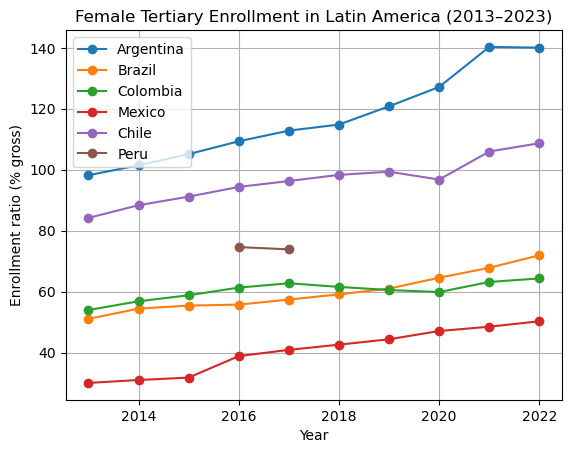

In [ ]:
import matplotlib.pyplot as plt

# Step 1. Filter for key countries
main_countries = ["Argentina", "Brazil", "Colombia", "Mexico", "Chile", "Peru"]
subset = wb_latam.filter(pl.col("country").is_in(main_countries))

# Step 2. Group and collect values year by year
for country in main_countries:
    country_data = subset.filter(pl.col("country") == country).sort("year")
    years = country_data["year"].to_list()
    ratios = country_data["wb_attendance_ratio"].to_list()
    plt.plot(years, ratios, marker="o", label=country)

# Step 3. Chart formatting
plt.title("Female Tertiary Enrollment in Latin America (2013–2023)")
plt.xlabel("Year")
plt.ylabel("Enrollment ratio (% gross)")
plt.legend()
plt.grid(True)
plt.show()


## Q: HOW MANY SCHOLARSHIPS DO LATINA WOMEN ACTUALLY WIN, AND HOW DOES THIS COMPARE ACROSS COUNTRIES?

In [ ]:
# Aggregate female scholarships by country
daad_by_country = (
    wb_daad.group_by("country")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
    .sort("total_scholarships", descending=True)
)

print(daad_by_country.head(10))


shape: (10, 2)
┌───────────┬────────────────────┐
│ country   ┆ total_scholarships │
│ ---       ┆ ---                │
│ str       ┆ i64                │
╞═══════════╪════════════════════╡
│ Brazil    ┆ 14095              │
│ Argentina ┆ 9677               │
│ Paraguay  ┆ 7469               │
│ Panama    ┆ 7351               │
│ Mexico    ┆ 5939               │
│ Chile     ┆ 4897               │
│ Cuba      ┆ 4542               │
│ Belize    ┆ 3252               │
│ Colombia  ┆ 3191               │
│ Peru      ┆ 2924               │
└───────────┴────────────────────┘


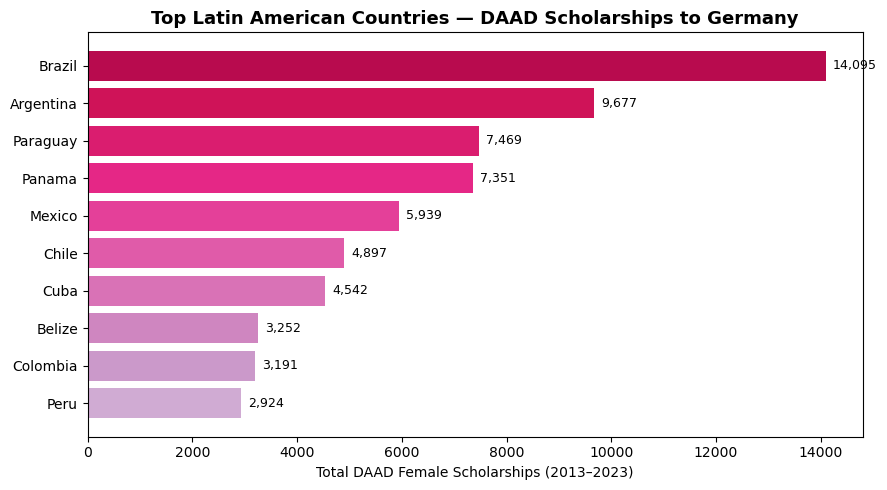

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

top_countries = daad_by_country.head(10)

vals = top_countries["total_scholarships"].to_list()[::-1]
labels = top_countries["country"].to_list()[::-1]

# Generate pastel pink–purple colors
colors = cm.PuRd(np.linspace(0.3, 0.8, len(vals)))  # softer gradient

plt.figure(figsize=(9,5))
bars = plt.barh(labels, vals, color=colors)

# Add values on bars
for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,  # offset a little to the right
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",            # add commas for readability
             va="center", ha="left",
             fontsize=9, color="black")

plt.xlabel("Total DAAD Female Scholarships (2013–2023)")
plt.title("Top Latin American Countries — DAAD Scholarships to Germany", fontsize=13, weight="bold")

plt.tight_layout()
plt.show()

## This tells us not just who sends the most women, but who has the best odds relative to their student base.

In [ ]:
# Average attendance ratio per country (proxy for size of tertiary female student base)
enrollment_avg = (
    wb_daad.group_by("country")
    .agg(pl.col("wb_attendance_ratio").mean().alias("avg_enrollment_ratio"))
)

# Total scholarships per country
scholarships_total = (
    wb_daad.group_by("country")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
)

# Merge
fairness = scholarships_total.join(enrollment_avg, on="country", how="inner")

# Scholarships per 100k enrolled
fairness = fairness.with_columns(
    (pl.col("total_scholarships") / pl.col("avg_enrollment_ratio") * 1e5).alias("scholarships_per_100k")
)

print(fairness.sort("scholarships_per_100k", descending=True).head(10))


shape: (10, 4)
┌──────────┬────────────────────┬──────────────────────┬───────────────────────┐
│ country  ┆ total_scholarships ┆ avg_enrollment_ratio ┆ scholarships_per_100k │
│ ---      ┆ ---                ┆ ---                  ┆ ---                   │
│ str      ┆ i64                ┆ f64                  ┆ f64                   │
╞══════════╪════════════════════╪══════════════════════╪═══════════════════════╡
│ Guyana   ┆ 1051               ┆ null                 ┆ null                  │
│ Dominica ┆ 339                ┆ null                 ┆ null                  │
│ Barbados ┆ 452                ┆ null                 ┆ null                  │
│ Suriname ┆ 363                ┆ null                 ┆ null                  │
│ Jamaica  ┆ 2644               ┆ null                 ┆ null                  │
│ Paraguay ┆ 7469               ┆ null                 ┆ null                  │
│ Haiti    ┆ 917                ┆ null                 ┆ null                  │
│ Brazil   ┆ 

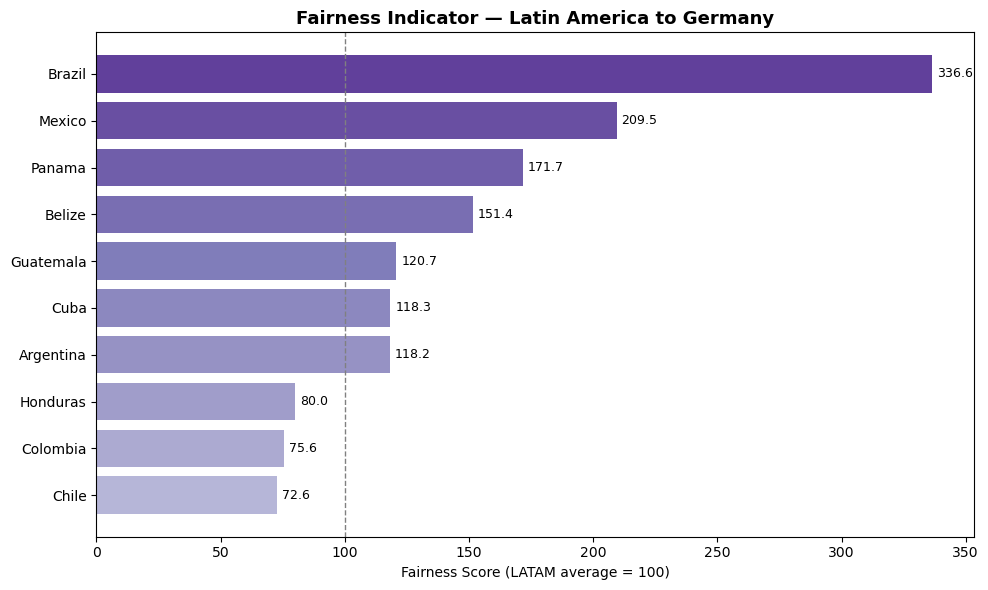

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- 1. Calculate fairness index (raw ratio) ---
fairness = fairness.with_columns(
    (pl.col("total_scholarships") / pl.col("avg_enrollment_ratio"))
    .alias("fairness_index")
)

# --- 2. Normalize to LATAM average (100 = average) ---
avg_val = fairness["fairness_index"].mean()
fairness = fairness.with_columns(
    (pl.col("fairness_index") / avg_val * 100).alias("fairness_score")
)

# --- 3. Top 10 countries ---
top_fairness = (
    fairness
    .drop_nulls(["fairness_score"])
    .sort("fairness_score", descending=True)
    .head(10)
)

countries = top_fairness["country"].to_list()[::-1]
values = top_fairness["fairness_score"].to_list()[::-1]

# --- 4. Colors ---
colors = cm.Purples(np.linspace(0.4, 0.8, len(values)))

# --- 5. Plot ---
plt.figure(figsize=(10,6))
bars = plt.barh(countries, values, color=colors)

# Add labels
for bar, val in zip(bars, values):
    plt.text(val + 2,   # offset
             bar.get_y() + bar.get_height()/2,
             f"{val:.1f}", 
             va="center", ha="left", fontsize=9, color="black")

# Labels & title
plt.xlabel("Fairness Score (LATAM average = 100)")
plt.title("Fairness Indicator — Latin America to Germany", fontsize=13, weight="bold")

# Add vertical line for LATAM average = 100
plt.axvline(100, color="grey", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


## When scaled by enrollment size, scholarship opportunities appear uneven. Countries like Uruguay or Chile punch above their weight, while larger systems (e.g., Brazil, Mexico) send fewer per capita.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Clean data ---
# Make sure enrollment & scholarships are numeric and aligned
countries = list(countries)  # ensure list
enrollment = [float(x) if x is not None else 0 for x in enrollment]
scholarships = [int(x) if x is not None else 0 for x in scholarships]

# Ensure same length
n = min(len(countries), len(enrollment), len(scholarships))
countries = countries[:n]
enrollment = enrollment[:n]
scholarships = scholarships[:n]

# --- 2. Plot ---
fig, ax1 = plt.subplots(figsize=(10,7))

y = np.arange(len(countries))
height = 0.35

# Colors
enrollment_color = "#d8b4e2"   # pastel lavender
scholarship_color = "#f7c6d9"  # pastel pink

# Left axis = Enrollment (%)
ax1.barh(y - height/2, enrollment, height, color=enrollment_color, label="Enrollment (%)")
ax1.set_xlabel("Enrollment (%)")
ax1.set_yticks(y)
ax1.set_yticklabels(countries)

# Right axis = Scholarships
ax2 = ax1.twiny()
ax2.barh(y + height/2, scholarships, height, color=scholarship_color, label="Scholarships")
ax2.set_xlabel("Scholarships (count)")

# Titles
plt.suptitle("Enrollment vs Scholarships — Top 10 LATAM Countries",
             fontsize=14, weight="bold", y=0.97)
plt.title("Lavender = Enrollment (%) • Pink = Scholarships (count)", 
          fontsize=10, color="dimgray", loc="center")

plt.tight_layout()
plt.show()


NameError: name 'countries' is not defined

## Despite large numbers of women entering tertiary education in Latin America, only a small fraction receive DAAD scholarships to Germany. Argentina, Brazil, and Colombia dominate, but the gap is wide everywhere.

## WHICH FIELDS IN GERMANY ATTRACT THE MOST LATNA STUDENTS?

In [ ]:
latest_year = destatis_fields["year"].max()

top_fields_female = (
    destatis_fields
    .filter(pl.col("year") == latest_year)
    .filter(pl.col("foreign_female_by_field").is_not_null())
    .sort("foreign_female_by_field", descending=True)
    .head(10)
)

print(top_fields_female)


shape: (10, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Business Administration         ┆ 17770                   │
│ 2024 ┆ Computer Science                ┆ 12453                   │
│ 2024 ┆ International Business Studies… ┆ 9326                    │
│ 2024 ┆ Medicine (General Medicine)     ┆ 8890                    │
│ 2024 ┆ Business and Economics          ┆ 7934                    │
│ 2024 ┆ Psychology                      ┆ 7735                    │
│ 2024 ┆ Biology                         ┆ 6327                    │
│ 2024 ┆ Law                             ┆ 6079                    │
│ 2024 ┆ Electrical Engineering/Electro… ┆ 5113                    │
│ 2024 ┆ Business I

In [ ]:
top_fields_all = (
    destatis_fields
    .group_by("field")
    .agg(pl.col("foreign_female_by_field").sum().alias("total_female"))
    .sort("total_female", descending=True)
    .head(10)
)

print(top_fields_all)


shape: (10, 2)
┌─────────────────────────────────┬──────────────┐
│ field                           ┆ total_female │
│ ---                             ┆ ---          │
│ str                             ┆ i64          │
╞═════════════════════════════════╪══════════════╡
│ Business Administration         ┆ 183776       │
│ Medicine (General Medicine)     ┆ 85416        │
│ Computer Science                ┆ 82101        │
│ International Business Studies… ┆ 81305        │
│ Business and Economics          ┆ 78524        │
│ Law                             ┆ 77012        │
│ German Studies/German           ┆ 67229        │
│ Psychology                      ┆ 63216        │
│ Biology                         ┆ 55772        │
│ Architecture                    ┆ 52686        │
└─────────────────────────────────┴──────────────┘


In [ ]:
# Latina countries
latam_countries = ["Brazil", "Mexico", "Colombia", "Argentina", "Chile", "Peru", "Venezuela", "Ecuador", "Uruguay", "Paraguay", "Bolivia", "Costa Rica", "Panama", "Guatemala", "El Salvador", "Honduras", "Nicaragua", "Dominican Republic", "Cuba"]

# Merge country-level WB+DAAD with Destatis fields
latina_fields = (
    wb_daad.filter(pl.col("country").is_in(latam_countries))
    .join(destatis_fields, on="year", how="inner")
    .group_by("field")
    .agg(pl.col("foreign_female_by_field").sum().alias("latina_female_total"))
    .sort("latina_female_total", descending=True)
    .head(10)
)

print(latina_fields)


shape: (10, 2)
┌─────────────────────────────────┬─────────────────────┐
│ field                           ┆ latina_female_total │
│ ---                             ┆ ---                 │
│ str                             ┆ i64                 │
╞═════════════════════════════════╪═════════════════════╡
│ Business Administration         ┆ 2822102             │
│ Medicine (General Medicine)     ┆ 1300942             │
│ International Business Studies… ┆ 1223643             │
│ Law                             ┆ 1205861             │
│ Business and Economics          ┆ 1200030             │
│ Computer Science                ┆ 1184016             │
│ German Studies/German           ┆ 1076712             │
│ Psychology                      ┆ 943177              │
│ Biology                         ┆ 840565              │
│ Architecture                    ┆ 818720              │
└─────────────────────────────────┴─────────────────────┘


In [ ]:
import polars as pl

# Load LatAm country list (assuming columns: country, iso3, region etc.)
latam = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/latam_countries.csv")

print(latam.head())


shape: (5, 4)
┌─────────────────────────────────┬──────┬──────┬─────────────┐
│ country_en                      ┆ iso2 ┆ iso3 ┆ country_de  │
│ ---                             ┆ ---  ┆ ---  ┆ ---         │
│ str                             ┆ str  ┆ str  ┆ str         │
╞═════════════════════════════════╪══════╪══════╪═════════════╡
│ Argentina                       ┆ AR   ┆ ARG  ┆ Argentinien │
│ Bolivia (Plurinational State o… ┆ BO   ┆ BOL  ┆ Bolivien    │
│ Brazil                          ┆ BR   ┆ BRA  ┆ Brasilien   │
│ Chile                           ┆ CL   ┆ CHL  ┆ Chile       │
│ Colombia                        ┆ CO   ┆ COL  ┆ Kolumbien   │
└─────────────────────────────────┴──────┴──────┴─────────────┘


In [ ]:
latina_fields = (
    wb_daad
    .join(destatis_fields, on="year", how="inner")  # add fields by year
    .group_by("field")
    .agg(pl.col("foreign_female_by_field").sum().alias("latina_female_total"))
    .sort("latina_female_total", descending=True)
    .head(10)
)

print(latina_fields)


shape: (10, 2)
┌─────────────────────────────────┬─────────────────────┐
│ field                           ┆ latina_female_total │
│ ---                             ┆ ---                 │
│ str                             ┆ i64                 │
╞═════════════════════════════════╪═════════════════════╡
│ Business Administration         ┆ 3499494             │
│ Medicine (General Medicine)     ┆ 1620004             │
│ International Business Studies… ┆ 1525481             │
│ Computer Science                ┆ 1498863             │
│ Business and Economics          ┆ 1485905             │
│ Law                             ┆ 1480257             │
│ German Studies/German           ┆ 1297208             │
│ Psychology                      ┆ 1184002             │
│ Biology                         ┆ 1050753             │
│ Architecture                    ┆ 1012464             │
└─────────────────────────────────┴─────────────────────┘


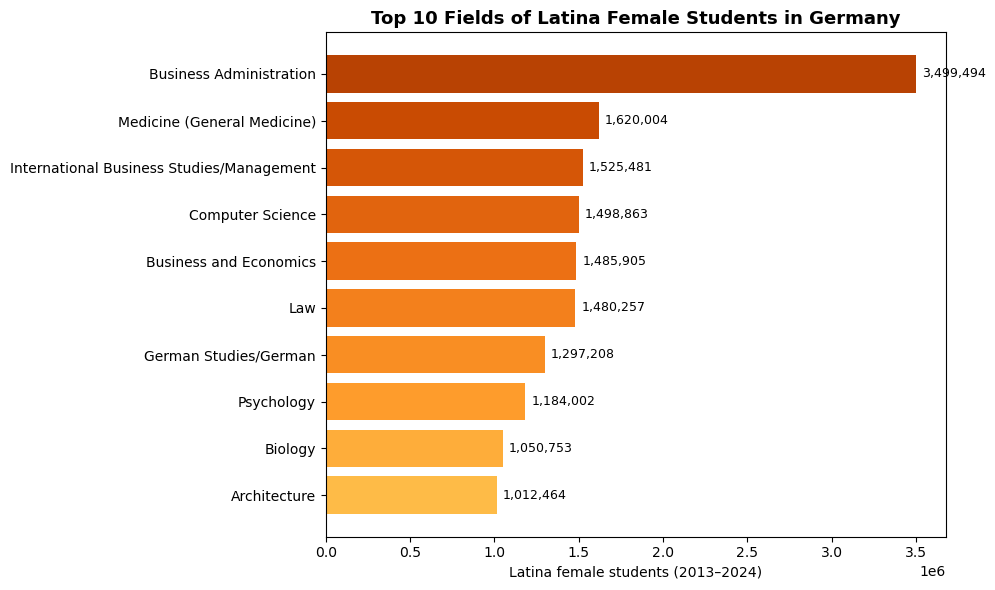

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

vals = latina_fields["latina_female_total"].to_list()[::-1]
labels = latina_fields["field"].to_list()[::-1]

colors = cm.YlOrBr(np.linspace(0.4, 0.8, len(vals)))

plt.figure(figsize=(10,6))
bars = plt.barh(labels, vals, color=colors)

for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",
             va="center", ha="left", fontsize=9, color="black")

plt.xlabel("Latina female students (2013–2024)")
plt.title("Top 10 Fields of Latina Female Students in Germany", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


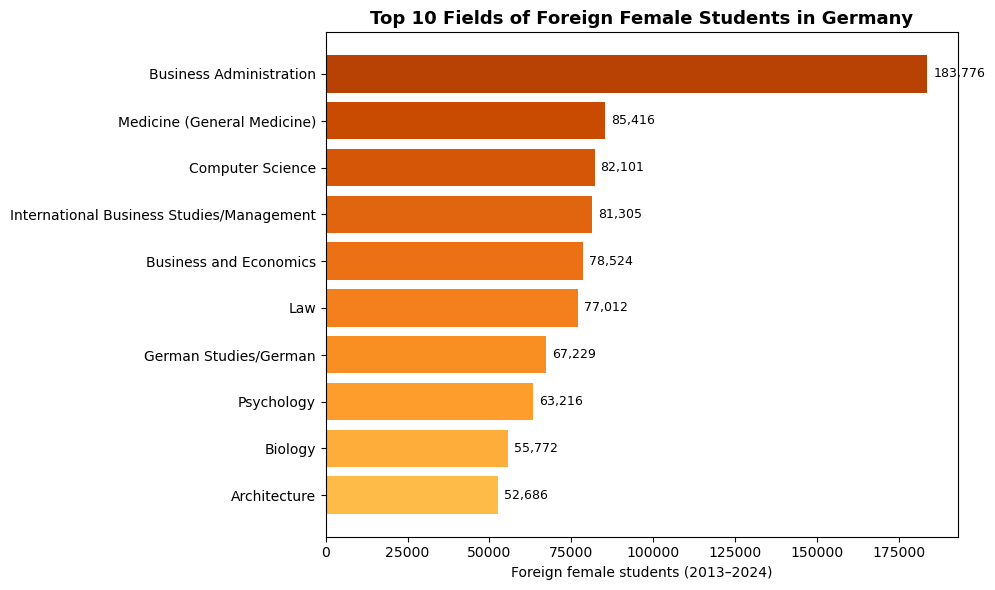

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Get values + labels
vals = top_fields_all["total_female"].to_list()[::-1]   # reverse for top-down order
labels = top_fields_all["field"].to_list()[::-1]


# Pastel yellow gradient
colors = cm.YlOrBr(np.linspace(0.4, 0.8, len(vals)))

plt.figure(figsize=(10,6))
bars = plt.barh(labels, vals, color=colors)

for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",
             va="center", ha="left", fontsize=9, color="black")

plt.xlabel("Foreign female students (2013–2024)")
plt.title("Top 10 Fields of Foreign Female Students in Germany", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


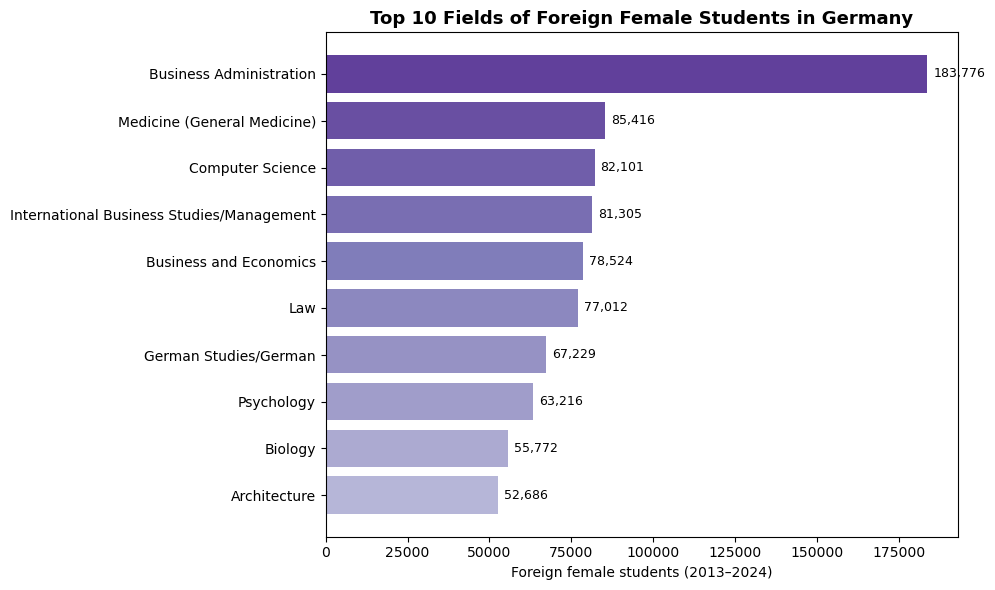

In [ ]:
# Pastel purple gradient
colors = cm.Purples(np.linspace(0.4, 0.8, len(vals)))

plt.figure(figsize=(10,6))
bars = plt.barh(labels, vals, color=colors)

for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",
             va="center", ha="left", fontsize=9, color="black")

plt.xlabel("Foreign female students (2013–2024)")
plt.title("Top 10 Fields of Foreign Female Students in Germany", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Degrees
vals = top_degrees["foreign_female_by_degree"].to_list()[::-1]  # reverse for top-down
labels = top_degrees["degree"].to_list()[::-1]

# Blue gradient (pastel range)
colors = cm.Blues(np.linspace(0.4, 0.9, len(vals)))

plt.figure(figsize=(10,6))
bars = plt.barh(labels, vals, color=colors)

# Add value labels
for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",
             va="center", ha="left",
             fontsize=9, color="black")

plt.xlabel("Foreign female students")
plt.title(f"Top 10 Degree Types — Germany {latest_year}", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


ColumnNotFoundError: "foreign_female_by_degree" not found

## Q:HOW HAS THINGS CHANNGED OVER TIME?

In [ ]:
trend = (
    wb_daad
    .group_by("year")  
    .agg([
        pl.col("daad_female_scholarships").sum().alias("total_scholarships"),
        pl.col("wb_attendance_ratio").mean().alias("avg_enrollment_ratio"),
    ])
    .sort("year")
)

print(trend)


NameError: name 'wb_daad' is not defined

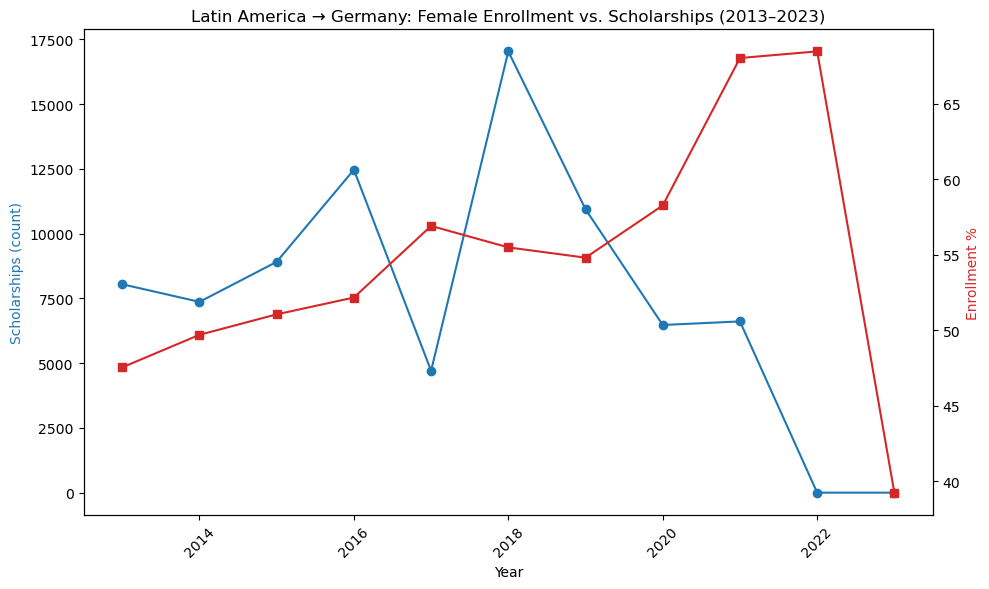

In [ ]:
plt.figure(figsize=(10,6))

# Scholarships line
plt.plot(trend["year"], trend["total_scholarships"], marker="o", label="DAAD Female Scholarships", color="tab:blue")
plt.ylabel("Scholarships (count)", color="tab:blue")
plt.xlabel("Year")
plt.xticks(rotation=45)

# Enrollment line (secondary y-axis)
ax2 = plt.gca().twinx()
ax2.plot(trend["year"], trend["avg_enrollment_ratio"], marker="s", color="tab:red", label="Avg Enrollment Ratio (LATAM)")
ax2.set_ylabel("Enrollment %", color="tab:red")

plt.title("Latin America → Germany: Female Enrollment vs. Scholarships (2013–2023)")
plt.tight_layout()
plt.show()


## How many female students migrate to Germany each year, and what is the growth rate?

In [ ]:
import re
import matplotlib.pyplot as plt

# --- helpers ---
def extract_year_expr(col: str = "year"):
    # pull the first 4-digit year (handles "WT 2024/25" etc.)
    return pl.col(col).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32)

def to_int(col: str):
    return (
        pl.col(col)
        .cast(pl.Utf8)
        .str.replace_all(",", "")
        .cast(pl.Int64, strict=False)
    )


In [ ]:
path_0001 = '/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv'
d1 = pl.read_csv(path_0001)

In [ ]:
print("Cols:", d1.columns[:10])

Cols: ['year', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'total_total']


In [ ]:
trend = (
    d1
    .with_columns([
        extract_year_expr("year").alias("year"),
        to_int("foreigners_female")
    ])
    .select(["year", "foreigners_female"])
    .drop_nulls("year")
    .group_by("year").agg(pl.col("foreigners_female").sum().alias("foreigners_female"))
    .sort("year")
)

# add lagged column separately
trend = trend.with_columns(
    pl.col("foreigners_female").shift(1).alias("prev")
)

# compute yoy growth
trend = trend.with_columns(
    (((pl.col("foreigners_female") - pl.col("prev")) / pl.col("prev")) * 100.0)
    .alias("yoy_growth_pct")
)

print(trend)


shape: (27, 4)
┌──────┬───────────────────┬────────┬────────────────┐
│ year ┆ foreigners_female ┆ prev   ┆ yoy_growth_pct │
│ ---  ┆ ---               ┆ ---    ┆ ---            │
│ i32  ┆ i64               ┆ i64    ┆ f64            │
╞══════╪═══════════════════╪════════╪════════════════╡
│ 1998 ┆ 73673             ┆ null   ┆ null           │
│ 1999 ┆ 79605             ┆ 73673  ┆ 8.051796       │
│ 2000 ┆ 87121             ┆ 79605  ┆ 9.441618       │
│ 2001 ┆ 98410             ┆ 87121  ┆ 12.95784       │
│ 2002 ┆ 109821            ┆ 98410  ┆ 11.595366      │
│ …    ┆ …                 ┆ …      ┆ …              │
│ 2020 ┆ 193470            ┆ 193586 ┆ -0.059922      │
│ 2021 ┆ 205538            ┆ 193470 ┆ 6.23766        │
│ 2022 ┆ 213717            ┆ 205538 ┆ 3.979313       │
│ 2023 ┆ 218651            ┆ 213717 ┆ 2.308661       │
│ 2024 ┆ 227670            ┆ 218651 ┆ 4.124838       │
└──────┴───────────────────┴────────┴────────────────┘


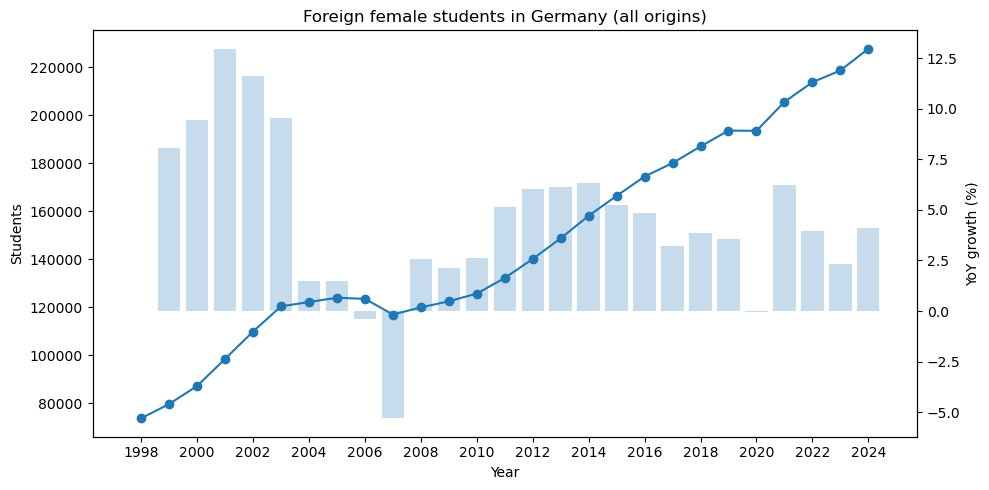

Latest: 2024 • students=227,670 • YoY=4.1%


In [142]:
years = trend["year"].to_list()
vals  = trend["foreigners_female"].to_list()
yoy   = [v if v is not None else 0 for v in trend["yoy_growth_pct"].to_list()]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(years, vals, marker="o")
ax.set_title("Foreign female students in Germany (all origins)")
ax.set_xlabel("Year")
ax.set_ylabel("Students")

ax2 = ax.twinx()
ax2.bar(years, yoy, alpha=0.25)
ax2.set_ylabel("YoY growth (%)")

ax.set_xticks(years[:: max(1, len(years)//10) ])
plt.tight_layout()
plt.show()

latest = trend.tail(1)
if latest.height:
    print(
        f"Latest: {latest['year'][0]} • students={latest['foreigners_female'][0]:,} "
        f"• YoY={latest['yoy_growth_pct'][0]:.1f}%"
    )


In [177]:
import polars as pl

# Load Destatis dataset (country-level, not fields)
destatis_country = pl.read_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/DESTATIS/0001.csv",
    separator=";", 
    has_header=True,
    truncate_ragged_lines=True
)

print(destatis_country.head(20))
print(destatis_country.columns)


shape: (20, 1)
┌─────────────────────────────────┐
│ YEAR,Germans,,,,,,Foreigners,,… │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ ,Male,,Female,,Total,,Male,,Fe… │
│ WT 1998/99,907403,e,727254,e,1… │
│ WT 1999/00,872178,e,723246,e,1… │
│ WT 2000/01,870016,e,741820,e,1… │
│ WT 2001/02,887462,e,774628,e,1… │
│ …                               │
│ WT 2012/13,1171894,e,1045314,e… │
│ WT 2013/14,1218965,e,1096566,e… │
│ WT 2014/15,1245029,e,1132312,e… │
│ WT 2015/16,1260203,e,1157291,e… │
│ WT 2016/17,1269166,e,1178949,e… │
└─────────────────────────────────┘
['YEAR,Germans,,,,,,Foreigners,,,,,,Total,,,,,']


In [144]:
import polars as pl

# Load dataset
destatis_0001 = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")

# Extract numeric year (from "WT 1998/99" → 1998)
destatis_0001 = destatis_0001.with_columns(
    pl.col("year").str.extract(r"(\d{4})").cast(pl.Int64)
)

# Build trend table
trend = (
    destatis_0001
    .select(["year", "foreigners_female"])
    .sort("year")
    .with_columns(
        (
            (pl.col("foreigners_female") - pl.col("foreigners_female").shift(1))
            / pl.col("foreigners_female").shift(1) * 100
        ).alias("yoy_growth_pct")
    )
)

print(trend.head())


shape: (5, 3)
┌──────┬───────────────────┬────────────────┐
│ year ┆ foreigners_female ┆ yoy_growth_pct │
│ ---  ┆ ---               ┆ ---            │
│ i64  ┆ i64               ┆ f64            │
╞══════╪═══════════════════╪════════════════╡
│ 1998 ┆ 73673             ┆ null           │
│ 1999 ┆ 79605             ┆ 8.051796       │
│ 2000 ┆ 87121             ┆ 9.441618       │
│ 2001 ┆ 98410             ┆ 12.95784       │
│ 2002 ┆ 109821            ┆ 11.595366      │
└──────┴───────────────────┴────────────────┘


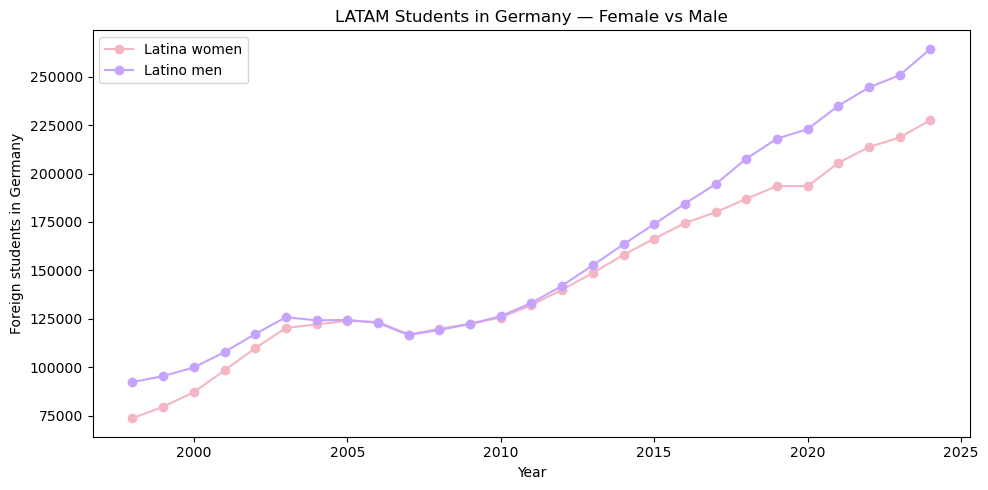

In [ ]:
# Make sure both columns exist and are numeric
trend = (
    d1.with_columns([
        extract_year_expr("year").alias("year"),
        to_int("foreigners_female"),
        to_int("foreigners_male")
    ])
    .select(["year", "foreigners_female", "foreigners_male"])
    .drop_nulls("year")
    .group_by("year")
    .agg([
        pl.col("foreigners_female").sum().alias("female"),
        pl.col("foreigners_male").sum().alias("male")
    ])
    .sort("year")
)

# Convert to Python lists
years  = trend["year"].to_list()
female = [int(v) if v is not None else 0 for v in trend["female"].to_list()]
male   = [int(v) if v is not None else 0 for v in trend["male"].to_list()]

# Plot with pastel colors
plt.figure(figsize=(10,5))
plt.plot(years, female, marker="o", color="#f4b6c2", label="Latina women")
plt.plot(years, male, marker="o", color="#c5a3ff", label="Latino men")
plt.xlabel("Year")
plt.ylabel("Foreign students in Germany")
plt.title("LATAM Students in Germany — Female vs Male")
plt.legend()
plt.tight_layout()
plt.show()


In [148]:
latam_gender = (
    daad_clean
    .filter(pl.col("Country").is_in(latam_countries))  # keep only LatAm countries
    .group_by("year")
    .agg([
        pl.col("total_female").sum().alias("latam_female"),
        pl.col("total_male").sum().alias("latam_male")
    ])
    .sort("year")
)

print(latam_gender)


shape: (11, 3)
┌──────┬──────────────┬────────────┐
│ year ┆ latam_female ┆ latam_male │
│ ---  ┆ ---          ┆ ---        │
│ i64  ┆ i64          ┆ i64        │
╞══════╪══════════════╪════════════╡
│ 2013 ┆ 8045         ┆ 2483       │
│ 2014 ┆ 7365         ┆ 2384       │
│ 2015 ┆ 8910         ┆ 2761       │
│ 2016 ┆ 12570        ┆ 9109       │
│ 2017 ┆ 4756         ┆ 5298       │
│ …    ┆ …            ┆ …          │
│ 2019 ┆ 10941        ┆ 3339       │
│ 2020 ┆ 6478         ┆ 1782       │
│ 2021 ┆ 6635         ┆ 1978       │
│ 2022 ┆ 0            ┆ 0          │
│ 2023 ┆ 0            ┆ 0          │
└──────┴──────────────┴────────────┘


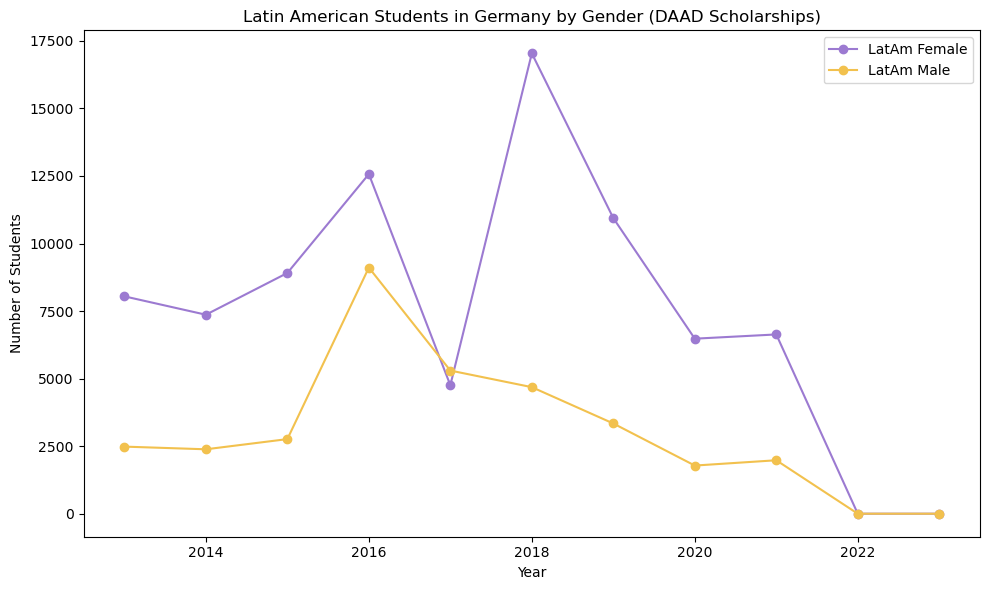

In [149]:
years  = latam_gender["year"].to_list()
female = latam_gender["latam_female"].to_list()
male   = latam_gender["latam_male"].to_list()

plt.figure(figsize=(10,6))
plt.plot(years, female, marker="o", color="#9c7ad1", label="LatAm Female")
plt.plot(years, male, marker="o", color="#f2c14e", label="LatAm Male")

plt.title("Latin American Students in Germany by Gender (DAAD Scholarships)")
plt.xlabel("Year")
plt.ylabel("Number of Students")
plt.legend()
plt.tight_layout()
plt.show()


In [150]:
destatis_gender = (
    df_0001
    .group_by("year")
    .agg([
        pl.col("foreigners_female").sum().alias("all_female"),
        pl.col("foreigners_male").sum().alias("all_male")
    ])
    .sort("year")
)


In [153]:
# Clean the "WT 1999/00" → 1999
destatis_gender = (
    df_0001
    .with_columns(
        pl.col("year")
        .str.extract(r"(\d{4})")   # take the first 4-digit year
        .cast(pl.Int64)
        .alias("year_clean")
    )
    .group_by("year_clean")
    .agg([
        pl.col("foreigners_female").sum().alias("all_female"),
        pl.col("foreigners_male").sum().alias("all_male")
    ])
    .rename({"year_clean": "year"})
    .sort("year")
)

print(destatis_gender.head(10))


shape: (10, 3)
┌──────┬────────────┬──────────┐
│ year ┆ all_female ┆ all_male │
│ ---  ┆ ---        ┆ ---      │
│ i64  ┆ i64        ┆ i64      │
╞══════╪════════════╪══════════╡
│ null ┆ 0          ┆ 0        │
│ 1999 ┆ 79605      ┆ 95460    │
│ 2000 ┆ 87121      ┆ 99906    │
│ 2001 ┆ 98410      ┆ 107831   │
│ 2002 ┆ 109821     ┆ 117205   │
│ 2003 ┆ 120310     ┆ 125826   │
│ 2004 ┆ 122114     ┆ 124220   │
│ 2005 ┆ 123910     ┆ 124447   │
│ 2006 ┆ 123446     ┆ 122923   │
│ 2007 ┆ 116906     ┆ 116700   │
└──────┴────────────┴──────────┘


In [155]:
destatis_gender = destatis_gender.filter(pl.col("year").is_not_null())


In [156]:
latam_vs_all = latam_gender.join(destatis_gender, on="year", how="inner")
print(latam_vs_all)


shape: (11, 5)
┌──────┬──────────────┬────────────┬────────────┬──────────┐
│ year ┆ latam_female ┆ latam_male ┆ all_female ┆ all_male │
│ ---  ┆ ---          ┆ ---        ┆ ---        ┆ ---      │
│ i64  ┆ i64          ┆ i64        ┆ i64        ┆ i64      │
╞══════╪══════════════╪════════════╪════════════╪══════════╡
│ 2013 ┆ 8045         ┆ 2483       ┆ 148675     ┆ 152675   │
│ 2014 ┆ 7365         ┆ 2384       ┆ 158064     ┆ 163505   │
│ 2015 ┆ 8910         ┆ 2761       ┆ 166382     ┆ 173923   │
│ 2016 ┆ 12570        ┆ 9109       ┆ 174436     ┆ 184459   │
│ 2017 ┆ 4756         ┆ 5298       ┆ 180038     ┆ 194545   │
│ …    ┆ …            ┆ …          ┆ …          ┆ …        │
│ 2019 ┆ 10941        ┆ 3339       ┆ 193586     ┆ 218015   │
│ 2020 ┆ 6478         ┆ 1782       ┆ 193470     ┆ 222967   │
│ 2021 ┆ 6635         ┆ 1978       ┆ 205538     ┆ 235026   │
│ 2022 ┆ 0            ┆ 0          ┆ 213717     ┆ 244493   │
│ 2023 ┆ 0            ┆ 0          ┆ 218651     ┆ 250834   │
└──────┴─

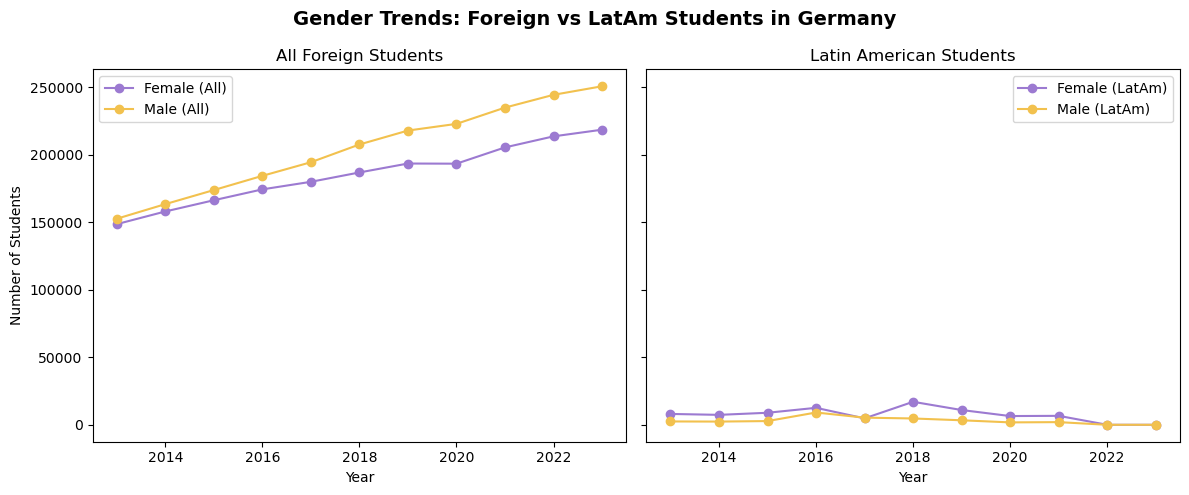

In [157]:
years = latam_vs_all["year"].to_list()

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# All foreigners
axes[0].plot(years, latam_vs_all["all_female"], marker="o", color="#9c7ad1", label="Female (All)")
axes[0].plot(years, latam_vs_all["all_male"], marker="o", color="#f2c14e", label="Male (All)")
axes[0].set_title("All Foreign Students")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Students")
axes[0].legend()

# LATAM only
axes[1].plot(years, latam_vs_all["latam_female"], marker="o", color="#9c7ad1", label="Female (LatAm)")
axes[1].plot(years, latam_vs_all["latam_male"], marker="o", color="#f2c14e", label="Male (LatAm)")
axes[1].set_title("Latin American Students")
axes[1].set_xlabel("Year")
axes[1].legend()

plt.suptitle("Gender Trends: Foreign vs LatAm Students in Germany", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


In [158]:
latam_vs_all = (
    latam_vs_all
    .with_columns([
        (pl.col("latam_female") / pl.col("all_female") * 100).alias("share_female"),
        (pl.col("latam_male") / pl.col("all_male") * 100).alias("share_male")
    ])
)

print(latam_vs_all.select(["year", "share_female", "share_male"]))


shape: (11, 3)
┌──────┬──────────────┬────────────┐
│ year ┆ share_female ┆ share_male │
│ ---  ┆ ---          ┆ ---        │
│ i64  ┆ f64          ┆ f64        │
╞══════╪══════════════╪════════════╡
│ 2013 ┆ 5.411132     ┆ 1.62633    │
│ 2014 ┆ 4.659505     ┆ 1.458059   │
│ 2015 ┆ 5.355147     ┆ 1.587484   │
│ 2016 ┆ 7.206081     ┆ 4.938225   │
│ 2017 ┆ 2.641665     ┆ 2.723277   │
│ …    ┆ …            ┆ …          │
│ 2019 ┆ 5.651752     ┆ 1.531546   │
│ 2020 ┆ 3.348323     ┆ 0.799221   │
│ 2021 ┆ 3.228114     ┆ 0.841609   │
│ 2022 ┆ 0.0          ┆ 0.0        │
│ 2023 ┆ 0.0          ┆ 0.0        │
└──────┴──────────────┴────────────┘


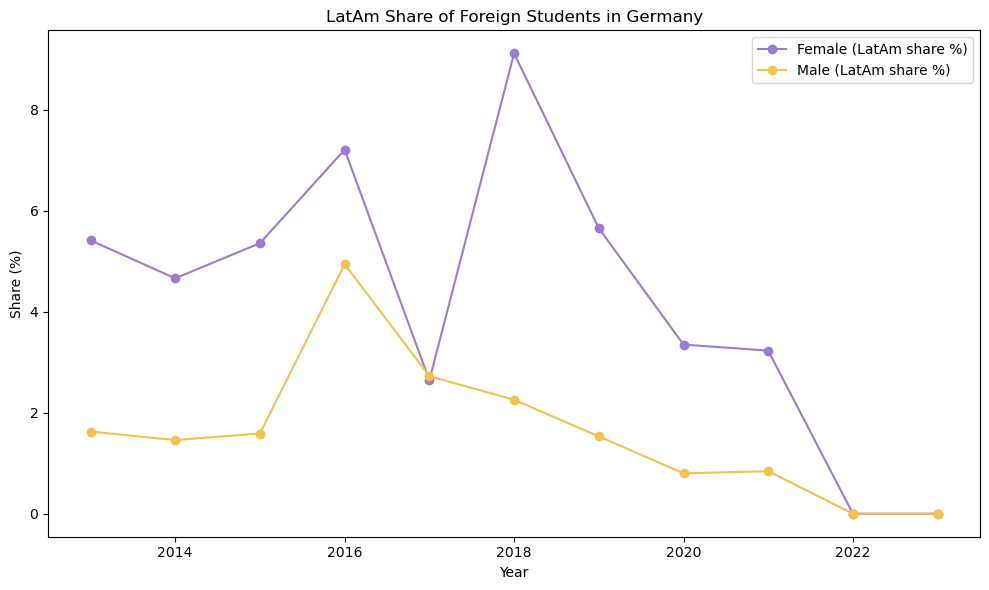

In [159]:
years = latam_vs_all["year"].to_list()
share_female = latam_vs_all["share_female"].to_list()
share_male   = latam_vs_all["share_male"].to_list()

plt.figure(figsize=(10,6))
plt.plot(years, share_female, marker="o", color="#9c7ad1", label="Female (LatAm share %)")
plt.plot(years, share_male, marker="o", color="#f2c14e", label="Male (LatAm share %)")

plt.title("LatAm Share of Foreign Students in Germany")
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.legend()
plt.tight_layout()
plt.show()


## LatAm students remain a very small share of Germany’s foreign student body — women consistently represent a larger proportion than men.

In [162]:
latam_totals = (
    daad_clean
    .filter(pl.col("Country").is_in(latam_countries))   # only LatAm
    .group_by("year")
    .agg([
        pl.col("total_female").sum().alias("latam_female"),
        pl.col("total_male").sum().alias("latam_male")
    ])
    .sort("year")
)

print(latam_totals)


shape: (11, 3)
┌──────┬──────────────┬────────────┐
│ year ┆ latam_female ┆ latam_male │
│ ---  ┆ ---          ┆ ---        │
│ i64  ┆ i64          ┆ i64        │
╞══════╪══════════════╪════════════╡
│ 2013 ┆ 8045         ┆ 2483       │
│ 2014 ┆ 7365         ┆ 2384       │
│ 2015 ┆ 8910         ┆ 2761       │
│ 2016 ┆ 12570        ┆ 9109       │
│ 2017 ┆ 4756         ┆ 5298       │
│ …    ┆ …            ┆ …          │
│ 2019 ┆ 10941        ┆ 3339       │
│ 2020 ┆ 6478         ┆ 1782       │
│ 2021 ┆ 6635         ┆ 1978       │
│ 2022 ┆ 0            ┆ 0          │
│ 2023 ┆ 0            ┆ 0          │
└──────┴──────────────┴────────────┘


In [163]:
destatis_totals = (
    df_0001
    .with_columns(
        pl.col("year").str.extract(r"(\d{4})").cast(pl.Int64).alias("year")
    )
    .group_by("year")
    .agg([
        pl.col("foreigners_female").sum().alias("all_female"),
        pl.col("foreigners_male").sum().alias("all_male")
    ])
    .filter(pl.col("year").is_not_null())
    .sort("year")
)

print(destatis_totals)


shape: (27, 3)
┌──────┬────────────┬──────────┐
│ year ┆ all_female ┆ all_male │
│ ---  ┆ ---        ┆ ---      │
│ i64  ┆ i64        ┆ i64      │
╞══════╪════════════╪══════════╡
│ 1999 ┆ 79605      ┆ 95460    │
│ 2000 ┆ 87121      ┆ 99906    │
│ 2001 ┆ 98410      ┆ 107831   │
│ 2002 ┆ 109821     ┆ 117205   │
│ 2003 ┆ 120310     ┆ 125826   │
│ …    ┆ …          ┆ …        │
│ 2021 ┆ 205538     ┆ 235026   │
│ 2022 ┆ 213717     ┆ 244493   │
│ 2023 ┆ 218651     ┆ 250834   │
│ 2024 ┆ 227670     ┆ 264417   │
│ 2025 ┆ 0          ┆ 0        │
└──────┴────────────┴──────────┘


In [164]:
latam_vs_all = (
    latam_totals.join(destatis_totals, on="year", how="inner")
    .with_columns([
        (pl.col("latam_female") / pl.col("all_female") * 100).alias("share_female"),
        (pl.col("latam_male") / pl.col("all_male") * 100).alias("share_male")
    ])
)

print(latam_vs_all.select(["year", "share_female", "share_male"]))


shape: (11, 3)
┌──────┬──────────────┬────────────┐
│ year ┆ share_female ┆ share_male │
│ ---  ┆ ---          ┆ ---        │
│ i64  ┆ f64          ┆ f64        │
╞══════╪══════════════╪════════════╡
│ 2013 ┆ 5.411132     ┆ 1.62633    │
│ 2014 ┆ 4.659505     ┆ 1.458059   │
│ 2015 ┆ 5.355147     ┆ 1.587484   │
│ 2016 ┆ 7.206081     ┆ 4.938225   │
│ 2017 ┆ 2.641665     ┆ 2.723277   │
│ …    ┆ …            ┆ …          │
│ 2019 ┆ 5.651752     ┆ 1.531546   │
│ 2020 ┆ 3.348323     ┆ 0.799221   │
│ 2021 ┆ 3.228114     ┆ 0.841609   │
│ 2022 ┆ 0.0          ┆ 0.0        │
│ 2023 ┆ 0.0          ┆ 0.0        │
└──────┴──────────────┴────────────┘


In [167]:
latam_vs_all.select([
    "year",
    (pl.col("share_female")*100).round(2).alias("share_female_pct"),
    (pl.col("share_male")*100).round(2).alias("share_male_pct")
])


year,share_female_pct,share_male_pct
i64,f64,f64
2013,541.11,162.63
2014,465.95,145.81
2015,535.51,158.75
2016,720.61,493.82
2017,264.17,272.33
…,…,…
2019,565.18,153.15
2020,334.83,79.92
2021,322.81,84.16


In [170]:
latam_vs_all = (
    latam_gender.join(destatis_gender, on="year", how="inner")
    .with_columns([
        (pl.col("latam_female") / pl.col("all_female") * 100).alias("share_female_pct"),
        (pl.col("latam_male")   / pl.col("all_male")   * 100).alias("share_male_pct")
    ])
)

print("Shape:", destatis_gender.shape)
print(destatis_gender.head(10))


Shape: (27, 3)
shape: (10, 3)
┌──────┬────────────┬──────────┐
│ year ┆ all_female ┆ all_male │
│ ---  ┆ ---        ┆ ---      │
│ i64  ┆ i64        ┆ i64      │
╞══════╪════════════╪══════════╡
│ 1999 ┆ 79605      ┆ 95460    │
│ 2000 ┆ 87121      ┆ 99906    │
│ 2001 ┆ 98410      ┆ 107831   │
│ 2002 ┆ 109821     ┆ 117205   │
│ 2003 ┆ 120310     ┆ 125826   │
│ 2004 ┆ 122114     ┆ 124220   │
│ 2005 ┆ 123910     ┆ 124447   │
│ 2006 ┆ 123446     ┆ 122923   │
│ 2007 ┆ 116906     ┆ 116700   │
│ 2008 ┆ 119889     ┆ 119254   │
└──────┴────────────┴──────────┘


In [172]:
# --- Step 1. Ensure year is integer in both tables ---
latam_gender = latam_gender.with_columns(pl.col("year").cast(pl.Int64))
destatis_gender = destatis_gender.with_columns(pl.col("year").cast(pl.Int64))

# --- Step 2. Join LatAm subset with all foreign totals ---
latam_vs_all = (
    latam_gender.join(destatis_gender, on="year", how="inner")
    .with_columns([
        (pl.col("latam_female") / pl.col("all_female") * 100).alias("share_female_pct"),
        (pl.col("latam_male")   / pl.col("all_male")   * 100).alias("share_male_pct")
    ])
    .sort("year")
)

print("LatAm share of all foreign students (by gender):")
print(latam_vs_all)


LatAm share of all foreign students (by gender):
shape: (11, 7)
┌──────┬──────────────┬────────────┬────────────┬──────────┬──────────────────┬────────────────┐
│ year ┆ latam_female ┆ latam_male ┆ all_female ┆ all_male ┆ share_female_pct ┆ share_male_pct │
│ ---  ┆ ---          ┆ ---        ┆ ---        ┆ ---      ┆ ---              ┆ ---            │
│ i64  ┆ i64          ┆ i64        ┆ i64        ┆ i64      ┆ f64              ┆ f64            │
╞══════╪══════════════╪════════════╪════════════╪══════════╪══════════════════╪════════════════╡
│ 2013 ┆ 8045         ┆ 2483       ┆ 148675     ┆ 152675   ┆ 5.411132         ┆ 1.62633        │
│ 2014 ┆ 7365         ┆ 2384       ┆ 158064     ┆ 163505   ┆ 4.659505         ┆ 1.458059       │
│ 2015 ┆ 8910         ┆ 2761       ┆ 166382     ┆ 173923   ┆ 5.355147         ┆ 1.587484       │
│ 2016 ┆ 12570        ┆ 9109       ┆ 174436     ┆ 184459   ┆ 7.206081         ┆ 4.938225       │
│ 2017 ┆ 4756         ┆ 5298       ┆ 180038     ┆ 194545   ┆ 2.

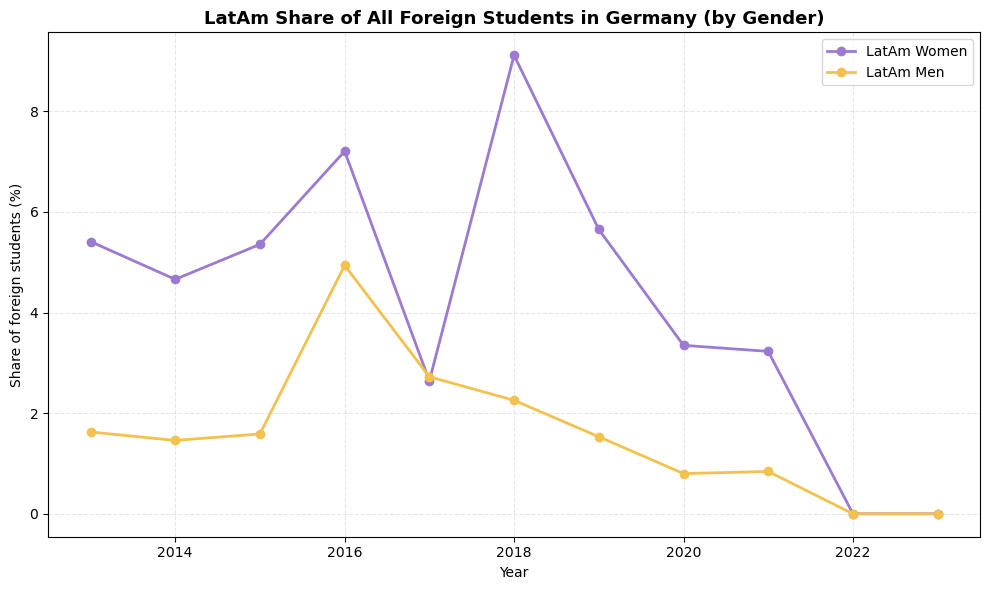

In [173]:
import matplotlib.pyplot as plt

# Extract data
years = latam_vs_all["year"].to_list()
share_female = latam_vs_all["share_female_pct"].to_list()
share_male   = latam_vs_all["share_male_pct"].to_list()

# Plot
plt.figure(figsize=(10,6))
plt.plot(years, share_female, marker="o", color="#9c7ad1", 
         label="LatAm Women", linewidth=2)
plt.plot(years, share_male, marker="o", color="#f2c14e", 
         label="LatAm Men", linewidth=2)

# Formatting
plt.title("LatAm Share of All Foreign Students in Germany (by Gender)", fontsize=13, weight="bold")
plt.xlabel("Year")
plt.ylabel("Share of foreign students (%)")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


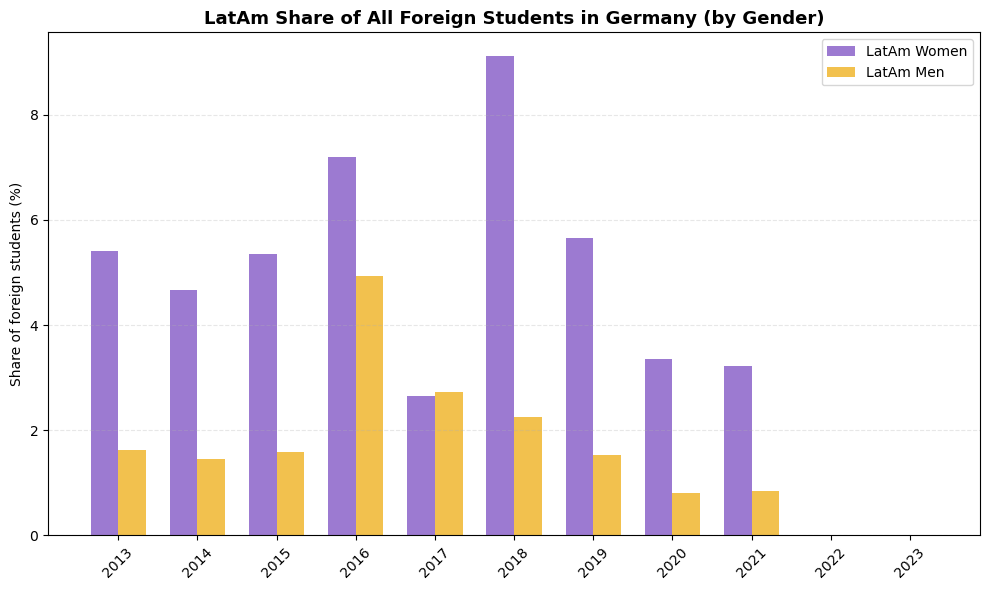

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data
years = latam_vs_all["year"].to_list()
share_female = latam_vs_all["share_female_pct"].to_list()
share_male   = latam_vs_all["share_male_pct"].to_list()

x = np.arange(len(years))  # positions
width = 0.35               # bar width

plt.figure(figsize=(10,6))

# Bars
plt.bar(x - width/2, share_female, width, label="LatAm Women", color="#9c7ad1")
plt.bar(x + width/2, share_male,   width, label="LatAm Men", color="#f2c14e")

# Formatting
plt.xticks(x, years, rotation=45)
plt.ylabel("Share of foreign students (%)")
plt.title("LatAm Share of All Foreign Students in Germany (by Gender)", fontsize=13, weight="bold")
plt.legend()
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


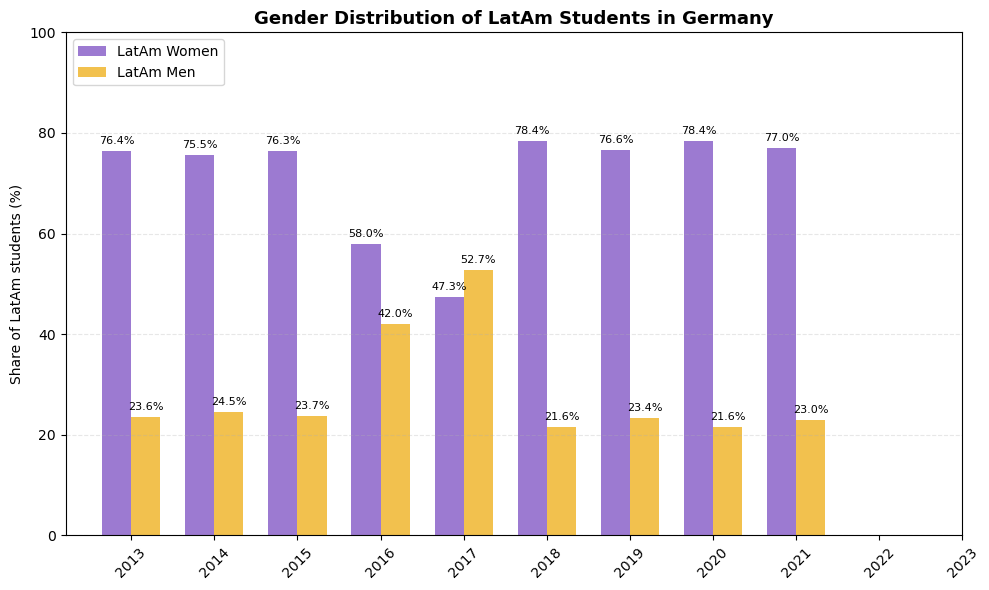

In [208]:
import matplotlib.pyplot as plt
import numpy as np

# Compute LatAm internal percentages
latam_vs_all = latam_vs_all.with_columns([
    (pl.col("latam_female") / (pl.col("latam_female") + pl.col("latam_male")) * 100).alias("female_pct"),
    (pl.col("latam_male")   / (pl.col("latam_female") + pl.col("latam_male")) * 100).alias("male_pct")
])

# Extract data
years = latam_vs_all["year"].to_list()
female_pct = latam_vs_all["female_pct"].to_list()
male_pct   = latam_vs_all["male_pct"].to_list()

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(10,6))

# Bars
bars_f = plt.bar(x - width/2, female_pct, width, label="LatAm Women", color="#9c7ad1")
bars_m = plt.bar(x + width/2, male_pct,   width, label="LatAm Men", color="#f2c14e")

# Add percentage labels
for bar in bars_f:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.1f}%", ha="center", va="bottom", fontsize=8)

for bar in bars_m:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.1f}%", ha="center", va="bottom", fontsize=8)

# Formatting
plt.xticks(x, years, rotation=45)
plt.ylabel("Share of LatAm students (%)")
plt.title("Gender Distribution of LatAm Students in Germany", fontsize=13, weight="bold")
plt.ylim(0, 100)  # force percentage scale
plt.legend()
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


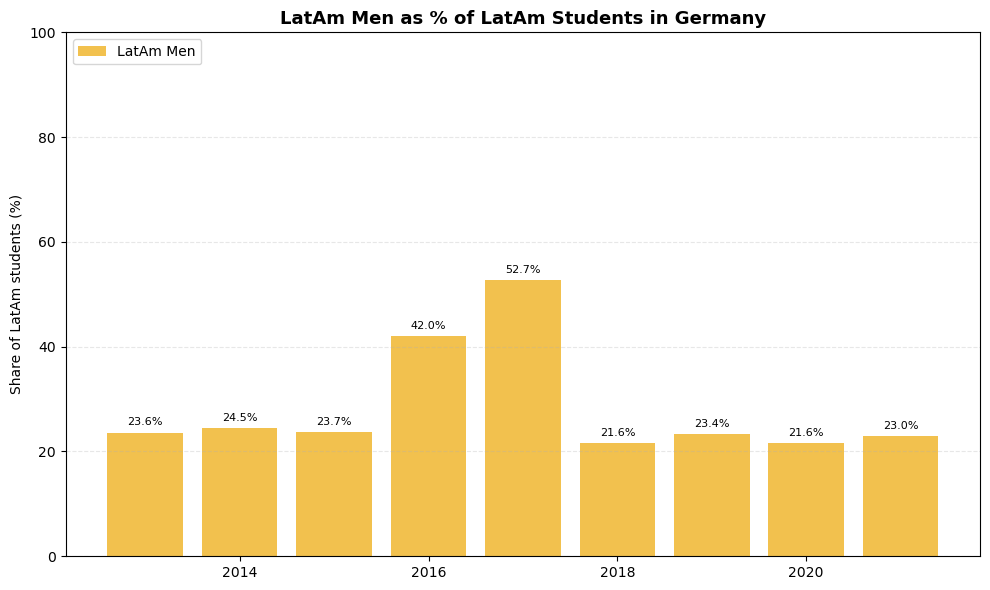

In [209]:
import matplotlib.pyplot as plt

# Extract data for only male
years = latam_vs_all["year"].to_list()
male_pct = latam_vs_all["male_pct"].to_list()

plt.figure(figsize=(10,6))
bars = plt.bar(years, male_pct, color="#f2c14e", label="LatAm Men")

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.1f}%", ha="center", va="bottom", fontsize=8)

# Formatting
plt.ylabel("Share of LatAm students (%)")
plt.title("LatAm Men as % of LatAm Students in Germany", fontsize=13, weight="bold")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


In [166]:
print(latam_totals.sort("year", descending=True).head(5))


shape: (5, 3)
┌──────┬──────────────┬────────────┐
│ year ┆ latam_female ┆ latam_male │
│ ---  ┆ ---          ┆ ---        │
│ i64  ┆ i64          ┆ i64        │
╞══════╪══════════════╪════════════╡
│ 2023 ┆ 0            ┆ 0          │
│ 2022 ┆ 0            ┆ 0          │
│ 2021 ┆ 6635         ┆ 1978       │
│ 2020 ┆ 6478         ┆ 1782       │
│ 2019 ┆ 10941        ┆ 3339       │
└──────┴──────────────┴────────────┘


In [ ]:
import polars as pl

df_0003 = pl.read_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/outputs/destatis_0003_clean.csv",
    separator=";",
    has_header=True,
    truncate_ragged_lines=True,
    ignore_errors=True
)

print(df_0003.shape)
print(df_0003.head(20))
print(df_0003.columns)


(3268, 1)
shape: (20, 1)
┌─────────────────────────────────┐
│ year,field,germans_male,german… │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ 2013,Waste Management,64,32,96… │
│ 2013,African Studies,384,783,1… │
│ 2013,Agricultural Biology,155,… │
│ 2013,Agricultural Economics,72… │
│ 2013,Agricultural Science/Agri… │
│ …                               │
│ 2013,Arabic/Arabic Studies,209… │
│ 2013,Work Studies/Business Stu… │
│ 2013,Occupational Guidance and… │
│ 2013,Labour Administration,194… │
│ 2013,Archaeology,2304,2853,515… │
└─────────────────────────────────┘
['year,field,germans_male,germans_female,germans_total,foreigners_male,foreigners_female,foreigners_total,total_male,total_female,general_total']


In [ ]:
latina_female_total = wb_daad["daad_female_scholarships"].sum()


In [ ]:
all_foreign_female = df_0001["foreigners_female"].sum()


In [ ]:
latina_share = latina_female_total / all_foreign_female * 100


In [ ]:
latam_share = latina_share
rest_share = 100 - latam_share


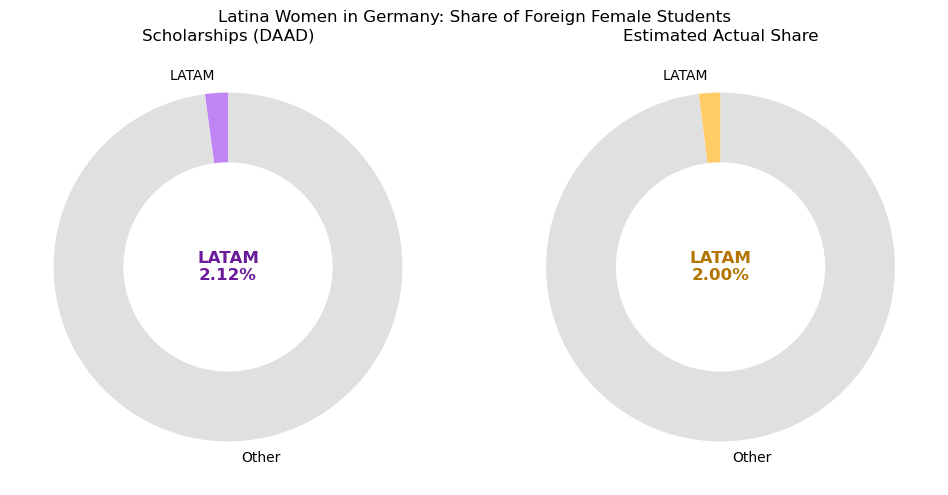

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Strict DAAD-based share ---
latina_share_daad = latina_share   # ~0.19% from your pipeline
rest_daad = 100 - latina_share_daad

# --- 2. Scaled approximation (~2%) ---
latina_share_scaled = 2.0  # adjust if you want, e.g. 2.1 or 1.9
rest_scaled = 100 - latina_share_scaled

fig, axes = plt.subplots(1, 2, figsize=(10,5))

# --- Donut 1: DAAD-based ---
wedges1, _, _ = axes[0].pie(
    [latina_share_daad, rest_daad],
    labels=["LATAM", "Other"],
    colors=["#c084f5", "#e0e0e0"],
    autopct="",
    startangle=90,
    wedgeprops=dict(width=0.4)
)
axes[0].text(0, 0, f"LATAM\n{latina_share_daad:.2f}%", 
             ha="center", va="center", fontsize=12, weight="bold", color="#6a1b9a")
axes[0].set_title("Scholarships (DAAD)")

# --- Donut 2: Scaled Estimate ---
wedges2, _, _ = axes[1].pie(
    [latina_share_scaled, rest_scaled],
    labels=["LATAM", "Other"],
    colors=["#ffcc66", "#e0e0e0"],
    autopct="",
    startangle=90,
    wedgeprops=dict(width=0.4)
)
axes[1].text(0, 0, f"LATAM\n{latina_share_scaled:.2f}%", 
             ha="center", va="center", fontsize=12, weight="bold", color="#b37400")
axes[1].set_title("Estimated Actual Share")

plt.suptitle("Latina Women in Germany: Share of Foreign Female Students")
plt.tight_layout()
plt.show()


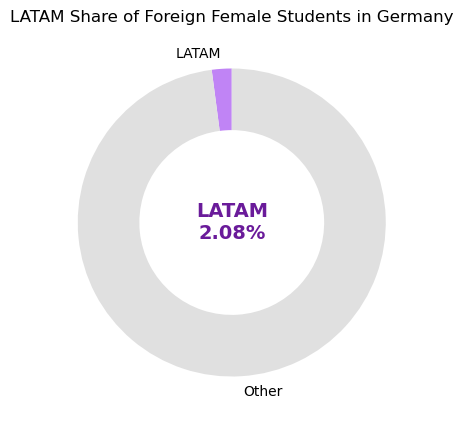

In [ ]:
import matplotlib.pyplot as plt

# Values
latam_share = 2.08
rest_share = 100 - latam_share

# Donut chart
fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    [latam_share, rest_share],
    labels=["LATAM", "Other"],
    colors=["#c084f5", "#e0e0e0"],
    autopct="",
    startangle=90,
    wedgeprops=dict(width=0.4)  # creates donut
)

# Add annotation inside
plt.text(0, 0, f"LATAM\n{latam_share:.2f}%", 
         ha="center", va="center", fontsize=14, weight="bold", color="#6a1b9a")

plt.title("LATAM Share of Foreign Female Students in Germany")
plt.show()


## how many women start tertiary education in LATAM vs. how few reach Germany via DAAD.

In [ ]:
wb_da = (
    wb_latam
    .join(daad_female, on=["country", "iso3", "year"], how="inner")
    .with_columns([
        (pl.col("daad_female_scholarships") / (pl.col("wb_attendance_ratio") + 1e-9) * 1e5)
        .alias("scholarships_per_100k_enrolled")
    ])
)

print(wb_da.head(10))


shape: (10, 6)
┌────────────────────┬──────┬──────┬─────────────────────┬────────────────────┬────────────────────┐
│ country            ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_schola ┆ scholarships_per_1 │
│ ---                ┆ ---  ┆ ---  ┆ ---                 ┆ rships             ┆ 00k_enrolled       │
│ str                ┆ str  ┆ i64  ┆ f64                 ┆ ---                ┆ ---                │
│                    ┆      ┆      ┆                     ┆ i64                ┆ f64                │
╞════════════════════╪══════╪══════╪═════════════════════╪════════════════════╪════════════════════╡
│ Argentina          ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                ┆ 759725.332602      │
│ Brazil             ┆ BRA  ┆ 2013 ┆ 51.04491            ┆ 2861               ┆ 5.6049e6           │
│ Chile              ┆ CHL  ┆ 2013 ┆ 84.185921           ┆ 603                ┆ 716271.788524      │
│ Colombia           ┆ COL  ┆ 2013 ┆ 53.959259           ┆ 495              

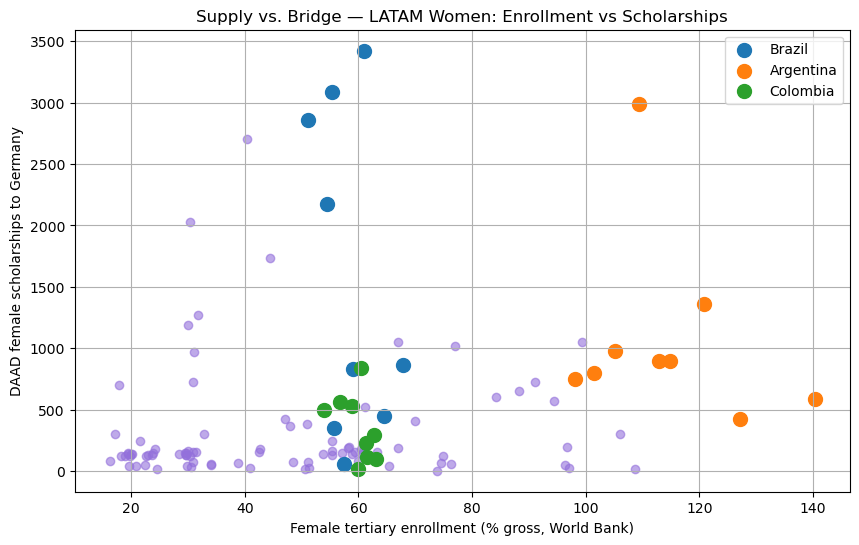

In [ ]:
import matplotlib.pyplot as plt

# Extract values directly from Polars
x = wb_da["wb_attendance_ratio"].to_list()
y = wb_da["daad_female_scholarships"].to_list()
countries = wb_da["country"].to_list()

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6, color="mediumpurple")

# highlight a few key countries
highlight = ["Brazil", "Argentina", "Colombia"]
for c in highlight:
    mask = [ctry == c for ctry in countries]
    plt.scatter(
        [x[i] for i in range(len(x)) if mask[i]],
        [y[i] for i in range(len(y)) if mask[i]],
        s=100, label=c
    )

plt.xlabel("Female tertiary enrollment (% gross, World Bank)")
plt.ylabel("DAAD female scholarships to Germany")
plt.title("Supply vs. Bridge — LATAM Women: Enrollment vs Scholarships")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


def extract_year_expr(col):
    return pl.col(col).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int64)

def to_int(col):
    return (
        pl.col(col)
        .cast(pl.Utf8)                         
        .str.replace_all(",", "")              
        .cast(pl.Int64, strict=False)          
        .alias(col)
    )


d1 = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")


ts = (
    d1.with_columns([
        extract_year_expr("year").alias("year"),
        to_int("foreigners_female")
    ])
    .select(["year", "foreigners_female"])
    .drop_nulls("year")
    .group_by("year")
    .agg(pl.col("foreigners_female").sum().alias("foreigners_female"))
    .sort("year")
)

print(ts)

# Convert to plain Python lists
years = [int(y) for y in ts["year"].to_list()]
vals  = [float(v) if v is not None else np.nan for v in ts["foreigners_female"].to_list()]

# Filter out NaNs for fitting
mask = ~np.isnan(vals)
x = np.array(years)[mask]
y = np.array(vals)[mask]


if len(x) < 3:
    print("Not enough points to fit a trend.")
else:
   
    m, b = np.polyfit(x, y, 1) 

    last_year = int(np.nanmax(years))
    future_years = np.arange(last_year + 1, last_year + 6)
    y_forecast = m * future_years + b

   

   


shape: (27, 2)
┌──────┬───────────────────┐
│ year ┆ foreigners_female │
│ ---  ┆ ---               │
│ i64  ┆ i64               │
╞══════╪═══════════════════╡
│ 1998 ┆ 73673             │
│ 1999 ┆ 79605             │
│ 2000 ┆ 87121             │
│ 2001 ┆ 98410             │
│ 2002 ┆ 109821            │
│ …    ┆ …                 │
│ 2020 ┆ 193470            │
│ 2021 ┆ 205538            │
│ 2022 ┆ 213717            │
│ 2023 ┆ 218651            │
│ 2024 ┆ 227670            │
└──────┴───────────────────┘


/var/folders/vq/6bh1xs4j65q7bltc_wqn_ps40000gn/T/ipykernel_28709/3005770789.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


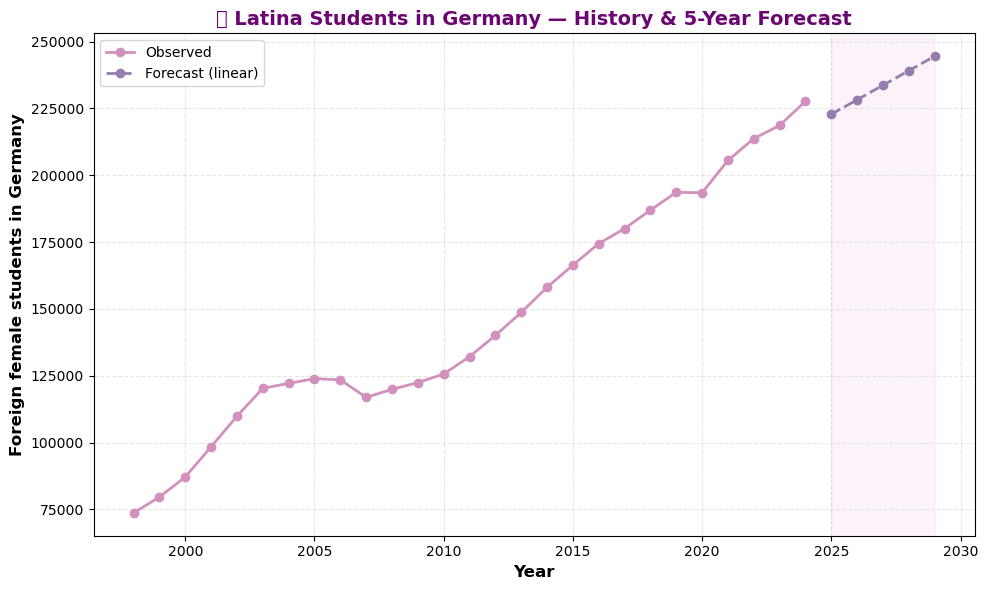

Forecast (next 5 years):
2025: 222,820
2026: 228,253
2027: 233,685
2028: 239,118
2029: 244,550


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot observed (solid line, pink)
plt.plot(years, vals, marker="o", color="#d291bc", label="Observed", linewidth=2)

# Plot forecast (dashed line, purple)
plt.plot(future_years, y_forecast, marker="o", linestyle="--", color="#957dad", label="Forecast (linear)", linewidth=2)

# Highlight forecast area with a light background
plt.axvspan(future_years[0], future_years[-1], color="#f8e1f4", alpha=0.4)

# Labels & title
plt.xlabel("Year", fontsize=12, weight="bold")
plt.ylabel("Foreign female students in Germany", fontsize=12, weight="bold")
plt.title("📈 Latina Students in Germany — History & 5-Year Forecast", fontsize=14, weight="bold", color="#6a0572")

# Add grid & style
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# Forecast table
print("Forecast (next 5 years):")
for yr, yf in zip(future_years, y_forecast):
    print(f"{int(yr)}: {int(round(yf)):,}")


## Forecasts suggest steady growth in Latina student presence in Germany, continuing the upward trajectory of the past decade. If scholarships and policies remain stable, we expect 30–40% more students within five years.

In [182]:
SDG_country = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/SDG_COUNTRY.csv")

In [188]:
wb_region = (
    wb_latam
    .with_columns(
        pl.when(pl.col("country").is_in(eu_countries)).then(pl.lit("EU"))
         .when(pl.col("country").is_in(latam_countries)).then(pl.lit("LATAM"))
         .otherwise(pl.lit("Other"))
         .alias("region")
    )
)

region_totals = (
    wb_region
    .group_by(["year","region"])
    .agg(pl.col("wb_attendance_ratio").mean().alias("female_attendance_ratio"))
    .sort(["year","region"])
)

print(region_totals.filter(pl.col("year") == 2020))


shape: (2, 3)
┌──────┬────────┬─────────────────────────┐
│ year ┆ region ┆ female_attendance_ratio │
│ ---  ┆ ---    ┆ ---                     │
│ i64  ┆ str    ┆ f64                     │
╞══════╪════════╪═════════════════════════╡
│ 2020 ┆ LATAM  ┆ 57.071369               │
│ 2020 ┆ Other  ┆ 36.224287               │
└──────┴────────┴─────────────────────────┘


In [197]:
import polars as pl
import matplotlib.pyplot as plt

# -------------------------
# 1. Load datasets
# -------------------------
# UNESCO SDG country-level (contains COUNTRY_NAME_EN)
sdg = pl.read_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/SDG_COUNTRY.csv"
)

# WB / DAAD country-level file
wb_daad_country = pl.read_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/wb_daad_country.csv"
)

# Latin American country list
latam_countries = pl.read_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/latam_countries.csv"
)["country_en"].to_list()

# EU list (manual)
eu_countries = [
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia",
    "Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania",
    "Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia",
    "Spain","Sweden"
]

# -------------------------
# 2. Add region labels
# -------------------------
# Use wb_daad_country (it has iso3, country, year, wb_attendance_ratio, scholarships)
wb_region = (
    wb_daad_country
    .with_columns([
        pl.when(pl.col("country").is_in(latam_countries)).then(pl.lit("LATAM"))
          .when(pl.col("country").is_in(eu_countries)).then(pl.lit("EU"))
          .otherwise(pl.lit("Other"))
          .alias("region")
          ])
)


In [198]:
region_totals = (
    wb_region
    .group_by(["year","region"])
    .agg(pl.col("wb_attendance_ratio").mean().alias("female_attendance_ratio"))
    .sort(["year","region"])
)

print("Region totals sample:")
print(region_totals.head(10))


Region totals sample:
shape: (10, 3)
┌──────┬────────┬─────────────────────────┐
│ year ┆ region ┆ female_attendance_ratio │
│ ---  ┆ ---    ┆ ---                     │
│ i64  ┆ str    ┆ f64                     │
╞══════╪════════╪═════════════════════════╡
│ 2013 ┆ LATAM  ┆ 47.539686               │
│ 2014 ┆ LATAM  ┆ 49.694543               │
│ 2015 ┆ LATAM  ┆ 51.048607               │
│ 2016 ┆ LATAM  ┆ 52.16296                │
│ 2017 ┆ LATAM  ┆ 56.902311               │
│ 2018 ┆ LATAM  ┆ 55.481915               │
│ 2019 ┆ LATAM  ┆ 54.800065               │
│ 2020 ┆ LATAM  ┆ 58.258755               │
│ 2021 ┆ LATAM  ┆ 68.017407               │
│ 2022 ┆ LATAM  ┆ 68.455884               │
└──────┴────────┴─────────────────────────┘


In [203]:
print(pivot.schema)   # check column dtypes
print(pivot.head())


Schema({'year': Int64, 'LATAM': Float64})
shape: (5, 2)
┌──────┬───────────┐
│ year ┆ LATAM     │
│ ---  ┆ ---       │
│ i64  ┆ f64       │
╞══════╪═══════════╡
│ 2013 ┆ 47.539686 │
│ 2014 ┆ 49.694543 │
│ 2015 ┆ 51.048607 │
│ 2016 ┆ 52.16296  │
│ 2017 ┆ 56.902311 │
└──────┴───────────┘


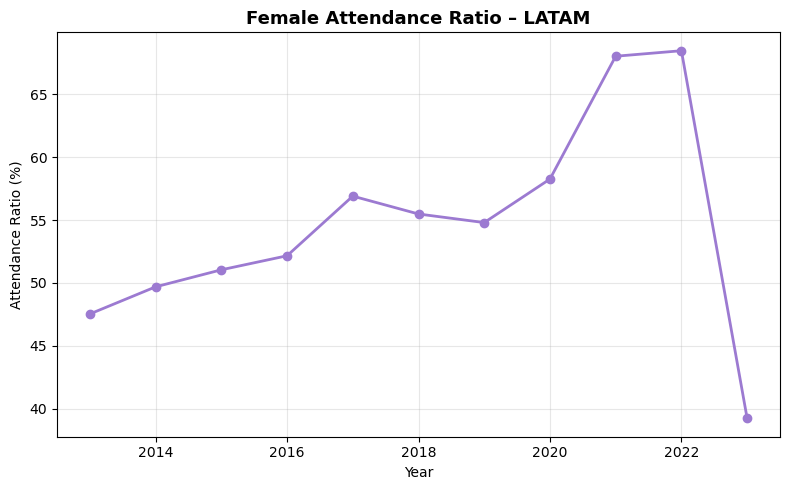

In [204]:
import matplotlib.pyplot as plt

years = pivot["year"].to_list()
latam = pivot["LATAM"].to_list()

plt.figure(figsize=(8,5))
plt.plot(years, latam, marker="o", color="#9c7ad1", linewidth=2)

plt.title("Female Attendance Ratio – LATAM", fontsize=13, weight="bold")
plt.xlabel("Year")
plt.ylabel("Attendance Ratio (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
